In [22]:
%tensorflow_version 2.x
import tensorflow as tf
print("TensorFlow version " + tf.__version__)
from google.colab import drive
drive.mount('/content/drive')
import glob, time, os, joblib, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, \
                                  RobustScaler, QuantileTransformer
from tensorflow.keras.callbacks import EarlyStopping

my_dir = "./drive/My Drive/colab-notebooks"
# TODO: import emuradex properly
sys.path.insert(1, '{}/{}/'.format(my_dir, "emuradex/"))
import emuradex
import importlib
importlib.reload(emuradex)

TensorFlow version 2.3.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<module 'emuradex' from './drive/My Drive/colab-notebooks/emuradex/emuradex.py'>

In [23]:
import sklearn
!python --version;
tf.keras.__version__, sklearn.__version__, pd.__version__, joblib.__version__

Python 3.6.9


('2.4.0', '0.22.2.post1', '1.0.5', '0.16.0')

Set up a training strategy (eg., distributed training with a GPU)


In [24]:
if tf.config.list_physical_devices('gpu'):
  strategy = tf.distribute.MirroredStrategy()
else:  # use default strategy
  strategy = tf.distribute.get_strategy() 
print(tf.python.client.device_lib.list_local_devices())
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17724368865937428803
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6847495803816315689
physical_device_desc: "device: XLA_CPU device"
]
Number of devices: 1


In [34]:
molecule = "CS".upper()
transitions = np.arange(1, 21)
flux_cut = 200.0 # K km/s
tau_cut = 1000.0

my_dir = os.path.dirname(emuradex.__file__)
radex_data = os.path.join(my_dir, "data")
testing_dir = os.path.join(my_dir, "testing")
gridsearch_dir = os.path.join(testing_dir, "cv_grid_search/%s" % molecule)
models_dir = os.path.join(my_dir, "models/%s" % molecule)
new_models_dir = os.path.join(models_dir, "new_models")

paths_str = [testing_dir, gridsearch_dir, models_dir, new_models_dir]

for path in paths_str:
    if not os.path.exists(path):
        os.makedirs(path)
        print("%s created" % path)
datafile = glob.glob(radex_data + "/radex%s*400k_lhs.csv" % molecule)[0]
molecule, datafile

('CS',
 './drive/My Drive/colab-notebooks/emuradex/data/radexCSflux-tau_400k_lhs.csv')

In [26]:
def plt_rcParams():
    plt.rcParams['font.family'] = "sans-serif"
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['axes.linewidth'] = 1
    plt.rcParams['lines.linewidth'] = 1.5
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['xtick.major.size'] = 6.0
    plt.rcParams['xtick.minor.size'] = 3.5
    plt.rcParams['ytick.major.size'] = 6.0
    plt.rcParams['ytick.minor.size'] = 3.5
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['legend.fontsize'] = 11
    plt.rcParams['legend.fancybox'] = True
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.5
    plt.rcParams['legend.title_fontsize'] = 12

plt_rcParams()

In [27]:
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [35]:
data_df = pd.read_csv(datafile, header=0, delimiter=',', dtype=np.float32)
data_df

,temperature,H2_dens,dvdr,mol_dens,flux_1,tau_1,flux_2,tau_2,flux_3,tau_3,flux_4,tau_4,flux_5,tau_5,flux_6,tau_6,flux_7,tau_7,flux_8,tau_8,flux_9,tau_9,flux_10,tau_10,flux_11,tau_11,flux_12,tau_12,flux_13,tau_13,flux_14,tau_14,flux_15,tau_15,flux_16,tau_16,flux_17,tau_17,flux_18,tau_18,flux_19,tau_19,flux_20,tau_20
0,55.083466,2.104427e+03,0.364137,3.750000e+17,19.420000,4.522000e+02,19.610001,1.664000e+03,19.389999,3.352000e+03,19.059999,5.120000e+03,18.639999,6.598000e+03,1.816000e+01,7.511000e+03,1.760000e+01,7.751000e+03,1.689000e+01,7.368000e+03,1.593000e+01,6.531000e+03,1.450000e+01,5.440000e+03,1.240000e+01,4.257000e+03,9.546000e+00,3.068000e+03,6.219000e+00,1.903000e+03,3.153000e+00,8.630000e+02,1.142000e+00,2.110000e+02,2.560000e-01,1.848000e+01,6.851000e-02,3.401000e-01,2.173000e-02,4.198000e-03,6.868000e-03,1.005000e-03,2.082000e-03,3.039000e-04
1,28.221251,7.853147e+07,0.112841,5.689970e+10,0.002291,7.460000e-04,0.007955,2.647000e-03,0.014160,4.869000e-03,0.018160,6.513000e-03,0.018710,7.042000e-03,1.623000e-02,6.432000e-03,1.213000e-02,5.083000e-03,7.936000e-03,3.522000e-03,4.581000e-03,2.158000e-03,2.345000e-03,1.175000e-03,1.068000e-03,5.703000e-04,4.342000e-04,2.472000e-04,1.576000e-04,9.590000e-05,5.120000e-05,3.330000e-05,1.490000e-05,1.040000e-05,3.900000e-06,2.900000e-06,9.150000e-07,7.270000e-07,1.930000e-07,1.640000e-07,3.680000e-08,3.330000e-08,6.310000e-09,6.110000e-09
2,19.063330,2.584736e+02,278.820679,2.443150e+12,0.006843,8.344000e-04,0.002897,1.018000e-03,0.000807,3.095000e-04,0.000192,3.310000e-05,0.000046,1.420000e-06,1.090000e-05,3.630000e-08,2.410000e-06,2.770000e-09,4.860000e-07,4.840000e-10,8.850000e-08,8.440000e-11,1.440000e-08,1.360000e-11,2.090000e-09,2.000000e-12,2.750000e-10,2.650000e-13,3.170000e-11,3.200000e-14,3.280000e-12,3.440000e-15,3.030000e-13,3.310000e-16,0.000000e+00,2.850000e-17,0.000000e+00,2.180000e-18,0.000000e+00,1.480000e-19,0.000000e+00,8.920000e-21,0.000000e+00,3.830000e-22
3,430.245422,6.840081e+03,23.268854,1.350000e+17,0.000000,1.740000e-17,0.000000,6.940000e-18,0.000000,4.460000e-18,0.000000,3.310000e-18,0.000000,2.630000e-18,0.000000e+00,2.190000e-18,0.000000e+00,1.870000e-18,0.000000e+00,1.630000e-18,0.000000e+00,1.450000e-18,0.000000e+00,1.310000e-18,0.000000e+00,1.190000e-18,0.000000e+00,1.090000e-18,0.000000e+00,1.000000e-18,0.000000e+00,9.310001e-19,0.000000e+00,8.690000e-19,0.000000e+00,8.140000e-19,0.000000e+00,7.670000e-19,0.000000e+00,7.240000e-19,0.000000e+00,6.860000e-19,0.000000e+00,6.520000e-19
4,4.175575,6.513040e+04,1.144076,4.878770e+11,0.028830,2.873000e-02,0.015210,4.909000e-02,0.002682,1.829000e-02,0.000195,2.318000e-03,0.000007,1.148000e-04,1.360000e-07,2.450000e-06,1.490000e-09,2.540000e-08,9.490000e-12,1.550000e-10,3.510000e-14,6.420000e-13,7.250000e-17,1.820000e-15,0.000000e+00,3.210000e-18,0.000000e+00,4.260000e-21,0.000000e+00,6.140000e-22,0.000000e+00,4.490000e-22,0.000000e+00,3.360000e-22,0.000000e+00,2.020000e-22,0.000000e+00,5.640000e-23,0.000000e+00,5.330000e-23,0.000000e+00,5.050000e-23,0.000000e+00,4.800000e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,22.213974,2.236937e+06,8.993009,2.410290e+13,1.440000,6.012000e-03,4.773000,2.452000e-02,7.469000,5.133000e-02,7.451000,6.893000e-02,5.177000,6.166000e-02,2.656000e+00,3.768000e-02,1.055000e+00,1.684000e-02,3.474000e-01,5.821000e-03,9.757000e-02,1.701000e-03,2.385000e-02,4.306000e-04,5.153000e-03,9.590000e-05,9.916000e-04,1.910000e-05,1.694000e-04,3.400000e-06,2.600000e-05,5.420000e-07,3.570000e-06,7.770000e-08,4.400000e-07,1.010000e-08,4.870000e-08,1.170000e-09,4.870000e-09,1.230000e-10,4.360000e-10,1.170000e-11,3.500000e-11,9.970000e-13
399996,91.491081,2.510997e+07,0.113142,2.720000e+15,10.350000,3.509000e+00,10.600000,1.352000e+01,10.530000,2.851000e+01,10.420000,4.632000e+01,10.300000,6.450000e+01,1.018000e+01,8.066000e+01,1.005000e+01,9.

In [ ]:
X_data = data_df.iloc[:,:3].values[:400000]
y_data = data_df.iloc[:,3].values[:400000]
cuts = [flux_cut, tau_cut]
radex_mask = get_radex_mask(y_data, cuts)

IndexError: ignored

# Get data

In [36]:
def get_data_from_df(dataframe, transitions_str):
    # check the required number of transition lines is available 
    jup_max_df = int(dataframe.columns[-1].split('_')[-1])
    jup_max_required = int(transitions_str[-1].split('_')[-1])
    assert jup_max_required <= jup_max_df, \
    "Input dataframe has highest transition Jup=%i -> Jlo=%i, but highest proposed Jup=%i." \
    % (jup_max_df, jup_max_df - 1, int(transitions_str[-1].split('_')[-1]))
    
    input_params_str = [col for col in data_df.columns 
                    if ("flux" not in col) & ("tau" not in col)]
    #input_params_str = ['temperature', 'H2_dens', 'dvdr', 'mol_dens']
    features = np.copy(dataframe[input_params_str].values)
    targets = np.copy(dataframe.iloc[:,len(input_params_str):].values)

    # features: 2D array [nsamples, nfeatures]
    # tragets: 3D array [nsamples, ntargets, ntransitions_str]
    X_data_all = np.log10(features)
    y_data_all = targets.reshape(-1, np.size(transitions_str)//2, 2)
    return X_data_all, y_data_all
    
def get_radex_mask(y, cuts):
    # apply masks to input data
    flux_cut, tau_cut = cuts
    #radex_nan_mask = np.isnan(y) + np.isnan(y)
    #radex_flux_mask = (y < 1e-5) | (y > flux_cut)
    radex_nan_mask = np.isnan(y[:,:,0]) + np.isnan(y[:,:,1])
    radex_flux_mask = (y[:,:,0] < 1e-5) | (y[:,:,0] > flux_cut)
    radex_tau_mask = (y[:,:,1] < -1.0) | (y[:,:,1] > tau_cut)
    radex_mask = radex_nan_mask + radex_flux_mask + radex_tau_mask
    #radex_mask = radex_nan_mask + radex_flux_mask
    return radex_mask

def plot_figure(nsub_x, nsub_y, sub_dimx=4, sub_dimy=2):
    n = nsub_x * nsub_y
    fig = plt.figure(figsize=(sub_dimx*nsub_x, sub_dimy*nsub_y))
    gs = fig.add_gridspec(nsub_y, nsub_x, wspace=0.0, hspace=0.0)#.tight_layout(fig)
    axes = []
    for i in range(n):
        axes.append(fig.add_subplot(gs[i // nsub_x, (n+i) % nsub_x], zorder=n-i))
    return axes

def plot_targets(axes, data, nbins=200, title='', annot=''):
    axes.hist(data, bins=nbins, color='b', alpha=0.6)
    axes.set_yscale('log')
    axes.set_xlabel(r"$\rm \mathcal{I} \; [K.km/s]$")
    axes.set_ylabel("No.")
    axes.set_title(title)
    axes.annotate(annot, xy=(0.2, 0.8), xycoords='axes fraction', fontsize=14)


# col names [flux_1, tau_1, flux_2, tau_2, ...]
transitions_str = transitions.astype(str)
transitions_str = transitions_str.repeat(2)
transitions_str[0::2] = ["flux_{}".format(i) for i in transitions_str[0::2]]
transitions_str[1::2] = ["tau_{}".format(i) for i in transitions_str[1::2]]

# split dataframe
X_data, y_data = get_data_from_df(data_df, transitions_str.astype(str))
cuts = [flux_cut, tau_cut]
radex_mask = get_radex_mask(y_data, cuts)
dim = int(np.round((X_data.shape[0])**(1/3))) # dimension size

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


### ... Temp functions ...

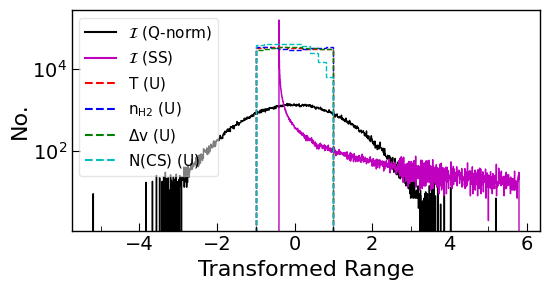

In [38]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(6,3), dpi=100)
ax1 = fig.add_subplot(111)
ax = fig.add_subplot(111, frameon=False)
ax.tick_params(axis='both', labelbottom=False, labelleft=False, left=False, bottom=False)
ax.set_ylabel("No.", labelpad=30)
ax1.set_xlabel(r"Transformed Range")
#ax2.set_xlabel(r"$\mathcal{I}$ [K km/s]")
#ax2.set_yscale('log')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(-8,8,2), minor=False)
ax1.set_xticks(np.arange(-6,6,1), minor=True)

xcolors = ['r', 'b', 'g', 'c']
labels = [r'$\rmT$ (U)', r'$\rm n_{H2}$ (U)', r'$\rmdv/dr$ (U)', r'$\rmN(%s)$ (U)' % molecule]

x_transformer = MinMaxScaler(feature_range=(-1,1))
y_transformer = QuantileTransformer(n_quantiles=1000, output_distribution='normal', 
                                    subsample=100000)
y_data_scaled = y_transformer.fit_transform(y_data[:,0,0][~radex_mask[:,0]].reshape(-1,1))
X_data_scaled = x_transformer.fit_transform(X_data[~radex_mask[:,0]])

ax1.hist(y_data_scaled, bins=1000, histtype='step', edgecolor='k', label=r'$\mathcal{I}$ (Q-norm)')
y_data_scaled = StandardScaler().fit_transform(y_data[:,0,0][~radex_mask[:,0]].reshape(-1,1))
ax1.hist(y_data_scaled, bins=1000, histtype='step', edgecolor='m', label=r'$\mathcal{I}$ (SS)')

[ax1.hist(X_data_scaled[:,i], histtype='step', color=xcolors[i], ls='--', label=labels[i]) for i in range(X_data.shape[1])]
cols = ['k', 'm', 'r', 'b', 'g', 'c']
lss = ['-', '-', '--', '--', '--', '--']
labels = [r'$\mathcal{I}$ (Q-norm)', r'$\mathcal{I}$ (SS)', r'$\rmT$ (U)', 
          r'$\rm n_{H2}$ (U)', r'$\rm\Delta v$ (U)', r'$\rmN(%s)$ (U)' % molecule]
lines = [Line2D([0], [0], color=cols[i], label=labels[i], ls=lss[i]) for i in range(len(cols))]
ax1.legend(handles=lines, loc=2)
plt.tight_layout()
#plt.savefig(my_dir + "/transf_orig_targets.pdf")

(1950,)


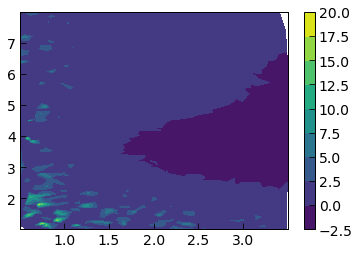

In [ ]:
#xx = X_data.copy()
#xx = xx[xx[:,3].argsort()]
#xx = xx[xx[:,2].argsort()]
#print(xx)

axis2 = [X_data[:,2].min(), X_data[:,2].max()]
axis3 = [X_data[:,3].min(), X_data[:,3].max()]

bins2 = np.linspace(axis2[0], axis2[1], 200)
bins3 = np.linspace(axis3[0], axis3[1], 200)
lb2, ub2 = bins2[:-1], bins2[1:]
lb3, ub3 = bins3[:-1], bins3[1:]

args = (X_data[:,3] >= lb3[80]) & (X_data[:,3] <= ub3[80])
print(X_data[args][:,0].shape)

#n = 30000
mask = radex_mask[args,0]
xx = X_data[args][~mask]
yy = y_data[args,0,1][~mask]
#plt.scatter(xx[:,0], xx[:,1], c=yy, s=0.5)
plt.tricontourf(xx[:,0], xx[:,1], yy)
plt.colorbar()
plt.show()

In [ ]:
for i, _ in enumerate(transitions):
    print("%s %i->%i" % (molecule, i+1, i), y_data[:,i][~radex_mask[:,i]].shape)

HCN 1->0 (319010, 2)
HCN 2->1 (304563, 2)
HCN 3->2 (292468, 2)
HCN 4->3 (275684, 2)
HCN 5->4 (256442, 2)
HCN 6->5 (237061, 2)
HCN 7->6 (220123, 2)
HCN 8->7 (205036, 2)
HCN 9->8 (191547, 2)
HCN 10->9 (179487, 2)
HCN 11->10 (168801, 2)
HCN 12->11 (158512, 2)
HCN 13->12 (149750, 2)
HCN 14->13 (141063, 2)
HCN 15->14 (133797, 2)
HCN 16->15 (126379, 2)
HCN 17->16 (120200, 2)
HCN 18->17 (113450, 2)
HCN 19->18 (107781, 2)
HCN 20->19 (101621, 2)


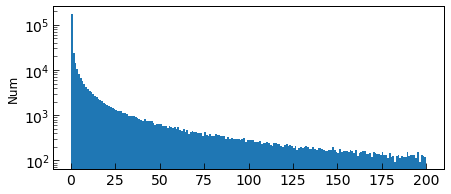

In [ ]:
fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(111)
ax.set_ylabel("Num")
for i, _ in enumerate(transitions[:1]):
    mask = radex_mask[:,i]
    yy = y_data[:,i,0][~mask]
    #yy = yy[yy < np.percentile(yy, 86)]
    ax.hist(yy, bins=200)
    ax.set_yscale('log')

plt.show()

In [ ]:
y_data.shape

(1000000, 10)

# Network Model

In [9]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Nadam
from tensorflow.keras.initializers import VarianceScaling, he_normal, lecun_normal, \
                                          TruncatedNormal, RandomUniform, GlorotNormal
from tensorflow.keras import Sequential

def model_fn(n_in, n_out, layers, activation, init, dropout=0.0, 
             loss='mse', optimiser=Adam, learning_rate=0.01):
    
    """input = Input(shape=(n_in,), name='input')
    for name, nodes in layers.items():
        if name == "dense1":
            x = Dense(nodes, activation=activation, 
                      kernel_initializer=init, name=name)(input)
        else:
            x = Dense(nodes, activation=activation, kernel_initializer=init, 
                      name=name)(x)
        x = Dropout(dropout)(x)
        x = BatchNormalization(momentum=0.9, center=True, scale=True)(x)
    output2 = Dense(1, activation=activation, name='output2')(x)
    #x = Dense(350, activation=activation, kernel_initializer=init, 
    #          name='dense3')(output2)
    #x = BatchNormalization(momentum=0.9, center=True, scale=True)(x)
    #x = tf.math.exp(tf.math.negative(output2, name='negative'), name='exp')
    output1 = Dense(1, activation=activation, name='output1')(x)
    outputs = [output1, output2]

    losses = {'output1':loss, 'output2':loss}
    lossWeights = {'output1':1.0, 'output2':0.2}
    optimizer = Adam(learning_rate)
    metrics = {'output1':'MeanSquaredError', 'output2':'MeanSquaredError'}
    model = Model(inputs=input, outputs=outputs)
    model.compile(loss=losses, loss_weights=lossWeights, 
                  optimizer=optimizer, metrics=metrics)"""

    model = Sequential(name='dnn')
    for name, nodes in layers.items():
        model.add(Dense(nodes, activation=activation, input_dim=n_in, 
                        kernel_initializer=init, name=name))
        model.add(Dropout(dropout))
        model.add(BatchNormalization(momentum=0.9, center=True, scale=True))
    model.add(Dense(n_out, activation=activation, 
                    kernel_initializer=init, name='output')) # output
    model.add(BatchNormalization(momentum=0.9, center=True, scale=True))
    
    model.compile(loss=loss, optimizer=optimiser(learning_rate), 
                  metrics=['MeanSquaredError'])
    return model

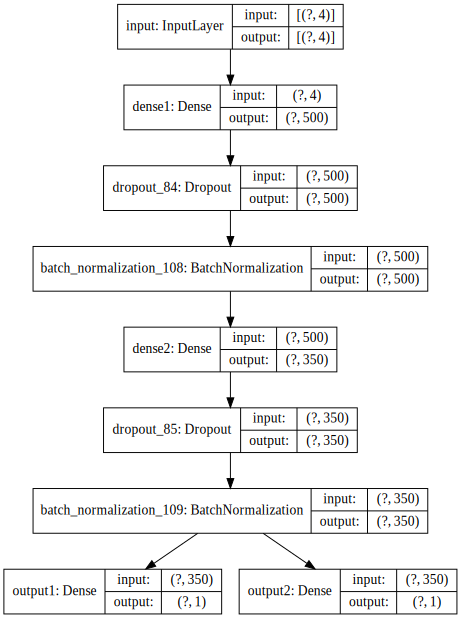

In [ ]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

#import livelossplot
#plot_losses = livelossplot.PlotLossesKeras()

model = model_fn(**best_params)
#model_img = os.path.join(mymodel_dir, "")
#tf.keras.utils.plot_model(model, to_file=dot_img_file, show_layer_names=True, show_shapes=True)
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=70).create(prog='dot', format='svg'))

In [10]:
def fetch_data(xdata, ydata, test_size=0.2, rstate=None):
    X_train, X_test, y_train, y_test = train_test_split(xdata, ydata, 
                                                        random_state=rstate,
                                                        test_size=test_size, 
                                                        shuffle=True)
    nfeatures, ntargets = xdata.shape[1], ydata.shape[1]
    X_train = X_train.reshape(-1, nfeatures)
    y_train = y_train.reshape(-1,ntargets)
    y_test = y_test.reshape(-1,ntargets)
    return X_train, X_test, y_train, y_test

# Tuning hyperparameters with GridSearch

### Helper functions

In [ ]:
import itertools

class KerasCallback(tf.keras.callbacks.Callback):
    """ Callback methods class for Keras models 

    Accumulates results from every cv-split and saves into
    files "model-000x.x--metrics.csv" for every 'cv_split' 
    cv-splits.

    Parameters
    ----------
    cv_dir :    directory to save cv-results to
    model_num : consecutive number of a model inside cv_dir
    cv_split :  number of cross-validation splits in GridSearch
    """
    def __init__(self, cv_dir, model_num, cv_split):
        self.model_ver = -1  # cross-validation label count
        self.path = cv_dir
        self.model_num = model_num
        self.cv_split = cv_split
        self.metrics = {}

    def on_train_begin(self, epoch, logs=None):
        if (self.model_ver + 1) % self.cv_split == 0:
            self.metrics = {}
        self.model_ver += 1
        
    def on_epoch_end(self, epoch, logs=None):
        """ Log metrics into a file """
        key_end = "_%i" % (self.model_ver % self.cv_split)
        for key, _ in logs.items():
            if key + key_end not in self.metrics:
                self.metrics[key + key_end] = []
        for key, val in logs.items():
            self.metrics[key + key_end].append(val)
        
    def on_train_end(self, epoch, logs=None):
        isplit = (self.model_ver + 1) // self.cv_split
        if (self.model_ver + 1) % self.cv_split == 0:
            file = "model-%04d.%i--metrics.csv" % (self.model_num, isplit)
            df = pd.DataFrame.from_dict(self.metrics)
            df.to_csv(self.path + file, header=True, index=False)
            print("\n %s \n" % file)
            message = "====== %i cv-split done ======\n"
            print(message % isplit)

def get_latest_num(save_dir, dir_root, increment=0):
    path = os.path.join(save_dir, dir_root)
    fnames = glob.glob(path + "*")
    if fnames:
        nums = []
        for fname in fnames:
            for item in fname.split('/'):
                if dir_root in item:
                    num = np.int32(item.split('-')[-1])
            nums.append(num)
        model_num = np.max(nums)
    else:
        model_num = 0
    return model_num + increment

def get_modeldir(save_dir, dir_root, increment=0):
    path = os.path.join(save_dir, dir_root)
    model_num = get_latest_num(save_dir, dir_root, increment=increment)
    modeldir = "%s-%04d/" % (path, model_num)
    if not os.path.exists(modeldir):
        os.makedirs(modeldir)
    return modeldir, model_num

def make_sets(nodes, n, ascending=False, descending=False, key='item'):
    """ Make set of unique value permutations
    
    Parameters
    ----------
    nodes : list or array; values to create combinations from.
    n : int; n-length tuples with all possible permutations.
    ascending : bool; force ascending order within every n-tuple.
    descending : bool; force descending order within every n-tuple.
    """
    if np.size(nodes) < n:
        raise ValueError("Size of 'nodes' is less than 'n'. "
                         "The size must be >= 'n'.")
    permuts = list(itertools.permutations(nodes, n))
    if descending:
        permuts = np.sort(permuts)[:,::-1]
    elif ascending:
        permuts = np.sort(permuts)
    try:
        permuts = np.unique(permuts, axis=0)
    except:
        pass
    d, combos = {}, []
    for comb in permuts:
        for i, elem in enumerate(comb):
            d['{}{}'.format(key,i+1)] = elem
        combos.append(d.copy())
    return combos

### Hyper-parameters for GridSearch

In [ ]:
# Hyperparameters to sample
initializers = [RandomUniform(minval=-1.0, maxval=1.0),
                TruncatedNormal(mean=0.0, stddev=1.0),
                he_normal(),
                VarianceScaling(scale=1.0, mode='fan_avg', 
                                distribution="truncated_normal")
                ]
dropouts = np.arange(0.0, 0.6, 0.1)
optimisers = [SGD, RMSprop, Adagrad, Adadelta, Adam, Nadam]
batch_sizes = np.arange(400, 1400, 200)

layers = [{'dense1':500},
          {'dense1':500, 'dense2':500},
          {'dense1':500, 'dense2':500, 'dense3':500},
          {'dense1':500, 'dense2':500, 'dense3':500, 'dense4':500},
          {'dense1':500, 'dense2':500, 'dense3':500, 'dense4':500, 'dense5':500}]

layer_nodes = np.arange(300, 1200, 200)
layer_nodes_set = make_sets(layer_nodes, 3, descending=True, key='dense')

### Running GridSearch

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# set up search params
N_EPOCHS = 50
CV_SPLIT = 5 # cross-validation split

# hyperparameters
initializer = [he_normal()]
layers = [{'dense1':300, 'dense2':200, 'dense3':100}]
hparams = {
    "n_in" : [4],
    "n_out" : [2],
    "layers" : layers,
    "activation" : ['relu'],
    "init" : initializer,
    "dropout" : [0.0],
    "loss" : ['mse'],
    "optimiser" : [Adam],
    "learning_rate" : [0.001],
    "batch_size" : [2000]
}

# preprocess training data
trans = 0
ntargets = y_data.shape[2]
mask = radex_mask[:,trans]
X = X_data[~mask]
y = y_data[:,trans][~mask].reshape(-1,ntargets)
x_transformer = MinMaxScaler(feature_range=(-1,1))
y_transformer = StandardScaler()
X_scaled = x_transformer.fit_transform(X)
y_scaled = y_transformer.fit_transform(y)

# create Keras model
with strategy.scope():
    keras_wrapped = KerasRegressor(build_fn=model_fn, epochs=N_EPOCHS)

    # wrap GridSearch model around the Keras model
    # note: GridSearchCV outputs -mse --> highest -mse is best
    grid = GridSearchCV(estimator=keras_wrapped, param_grid=hparams, 
                        scoring='neg_mean_squared_error', cv=CV_SPLIT, 
                        verbose=1, n_jobs=1, refit=False, return_train_score=True)
    cv_dir, model_num = get_modeldir(gridsearch_dir, "cv-results", 1)
    callbacks = [KerasCallback(cv_dir, model_num, CV_SPLIT)]
    grid.fit(X_scaled, y_scaled, validation_split=0.2, callbacks=callbacks)

    # save CV results
    df = pd.DataFrame.from_dict(grid.cv_results_)
    df.index += 1 # numbering of models from 1
    df.to_csv(cv_dir + "cv-results-%04d--%i-%.3f.csv" % 
            (model_num, df.shape[0], abs(grid.best_score_)), 
            header=True, index=True)

    print("best params = %s" % grid.best_params_)
    print("best score = %s" % grid.best_score_) 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/50
51/51 [==============================] - 1s 11ms/step - loss: 0.2927 - mean_squared_error: 0.2927 - val_loss: 0.2238 - val_mean_squared_error: 0.2238
Epoch 2/50
51/51 [==============================] - 0s 8ms/step - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0511 - val_mean_squared_error: 0.0511
Epoch 3/50
51/51 [==============================] - 0s 7ms/step - loss: 0.0557 - mean_squared_error: 0.0557 - val_loss: 0.0468 - val_mean_squared_error: 0.0468
Epoch 4/50
51/51 [==============================] - 0s 7ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 5/50
51/51 [==============================] - 0s 7ms/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0396 - val_mean_squared_error: 0.0396
Epoch 6/50
51/51 [==============================] - 0s 7ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 7/50
51/51 [=====================

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 10.6min finished


# Compare Parameter Combinations

### Load plot the metric scores


In [ ]:
import yaml

# specify cv-results directory
metrics_dir = os.path.join(gridsearch_dir, "cv-results-0003")
metrics_files = glob.glob(metrics_dir + "/model-*--metrics.csv")

# get metrics names and number of cv-splits
file = metrics_files[0]
_df = pd.read_csv(file, header=0, delimiter=',', dtype=np.float32)
cols = _df.columns
cols_root = ['_'.join(col.split('_')[:-1]) for col in cols]
metrics_str, cv_split = np.unique(cols_root, return_counts=True)
cv_split = cv_split[0]
print("available metrics in 'model-000x.x--metrics.csv' :", metrics_str)
print("cv-splits : ", cv_split)

# extract all hparams that varied during GridSearch
cvlog = glob.glob(metrics_dir + "/cv-results-*.csv")[0]
cvlog_df = pd.read_csv(cvlog, dtype='str')
hparams_df = pd.concat([pd.DataFrame([yaml.load(cvlog_df['params'][i])], dtype='str', index=[i]) \
                        for i in range(len(cvlog_df['params']))],
                       ignore_index=True) # dataframe with all param combinations
hparams_df

available metrics in 'model-000x.x--metrics.csv' : ['loss' 'mean_squared_error' 'val_loss' 'val_mean_squared_error']
cv-splits :  5


,activation,dropout,init,layers,learning_rate,loss,n_in,n_out
0,relu,0.02,<tensorflow.python.keras.initializers.initiali...,"{'dense1': 700, 'dense2': 600, 'dense3': 200}",0.01,mse,4,2
1,relu,0.02,<tensorflow.python.keras.initializers.initiali...,"{'dense1': 700, 'dense2': 600, 'dense3': 300}",0.01,mse,4,2
2,relu,0.02,<tensorflow.python.keras.initializers.initiali...,"{'dense1': 700, 'dense2': 600, 'dense3': 400}",0.01,mse,4,2
3,relu,0.02,<tensorflow.python.keras.initializers.initiali...,"{'dense1': 700, 'dense2': 600, 'dense3': 500}",0.01,mse,4,2


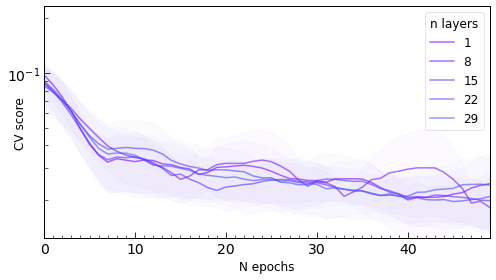

In [ ]:
from scipy.signal import savgol_filter

metric_key = 'val_mean_squared_error'
keys = ["{}_{}".format(metric_key, cv) for cv in np.arange(cv_split)]
metrics = []
for i, file in enumerate(metrics_files):
    metrics_df = pd.read_csv(file, header=0, delimiter=',', dtype=np.float32)
    metrics.append(metrics_df[keys].values)
metrics = np.dstack(metrics) # stack all models' metrics over nmodel axis
std_metrics = np.std(metrics, axis=1) # st.dev. over cv-splits for every model
metrics = np.average(metrics, axis=1) # average over cv-splits for every model
nmodels = metrics.shape[1] # number of all models in the grid
epochs = np.tile(np.arange(metrics.shape[0]).reshape(-1,1), (1, nmodels))

fig, ax = plt.subplots(figsize=(7,4))
ax.set_xlabel("N epochs")
ax.set_ylabel("CV score", labelpad=-20)
ax.set_yscale('log')
ax.set_xlim(epochs.min(), epochs.max())
ax.set_ylim(0.8*metrics.min(), 1.1*metrics.max())
ax.set_xticks(np.arange(epochs.max()), minor=True)
colors=iter(cm.rainbow(np.linspace(0,1,nmodels)))
labels = np.arange(1,nmodels+1,1).astype('str')

for i in range(0,nmodels,7):
    c = next(colors)
    y_smoothed = savgol_filter(metrics[:,i], 15, 3, mode='nearest')
    std_smoothed = savgol_filter(std_metrics[:,i], 15, 3, mode='nearest')
    ax.plot(epochs[:,i], y_smoothed, c=c, label=labels[i], 
            alpha=0.6, zorder=0)
    ax.fill_between(epochs[:,i], 
                    y_smoothed-std_smoothed,
                    y_smoothed+std_smoothed, 
                    color=c, alpha=0.02)
ax.legend(loc=1, title='n layers')
plt.tight_layout()
metrics_plot_dir = os.path.join(metrics_dir, 'plots')
if not os.path.exists(metrics_plot_dir):
    os.makedirs(metrics_plot_dir)
#plt.savefig(metrics_plot_dir + "/test_metrics.pdf")
plt.show()

In [ ]:
""" Load GridSearch results """
import yaml

cvlog = glob.glob(gridsearch_dir + "/cv-results-0001/cv-results-*.csv")[0]
cvlog_df = pd.read_csv(cvlog)
yaml.load(cvlog_df['params'][0])

{'activation': 'relu',
 'dropout': 0.02,
 'init': '<tensorflow.python.keras.initializers.initializers_v2.VarianceScaling object at 0x7f986ad284a8>',
 'layers': {'dense1': 500},
 'learning_rate': 0.01,
 'loss': 'mse',
 'n_in': 4,
 'n_out': 2}

In [ ]:
# extract all trained hparams as a dataframe
results_df = pd.concat([pd.DataFrame(yaml.load(cvlog_df['params'][i]), index=[i]) for i in range(len(cvlog_df['params']))], 
                    ignore_index=True) # dataframe with all param combinations
cols = [np.any(results_df.iloc[:,i] != results_df.iloc[:,i][0]) for i in range(results_df.shape[1])]
params_df = results_df.iloc[:,cols]

# extract all scores as a dataframe
scores = ['mean_train_score', 'std_train_score', 
          'mean_test_score', 'std_test_score']
scores_np = np.abs(np.array([cvlog_df[s] for s in scores]).T)
scores_df = pd.DataFrame(scores_np, columns=scores)

# dataframe with hparams + scores
results_df = pd.concat([params_df, scores_df], axis=1)
#cvlog_df['param_layers'], cvlog_df['mean_train_score'], cvlog_df['mean_test_score']
pd.DataFrame(cvlog_df).sort_values('rank_test_score')
results_df

,layers,mean_train_score,std_train_score,mean_test_score,std_test_score
0,NaN,0.045579,0.002023,0.047734,0.002332
1,NaN,0.020451,0.003296,0.023189,0.004578
2,NaN,0.015256,0.000158,0.016829,0.001154
3,NaN,0.032236,0.015806,0.032953,0.016512
4,NaN,0.019519,0.000169,0.021154,0.001768


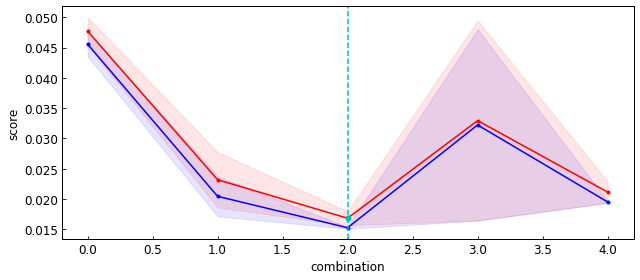

In [ ]:
n = params_df.shape[0]
xrange = np.arange(0, n, 1)

fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(111)
for i in range(1):
    
    minx = xrange[scores_df['mean_test_score'] == scores_df['mean_test_score'].min()]
    miny = scores_df['mean_test_score'].min()

    ax.plot(xrange, scores_df['mean_train_score'], 'b-', marker='.')
    ax.plot(xrange, scores_df['mean_test_score'], 'r-', marker='.')
    ax.fill_between(xrange, 
                    scores_df['mean_train_score'] - scores_df['std_train_score'],
                    scores_df['mean_train_score'] + scores_df['std_train_score'],
                    color='b', alpha=0.1)
    ax.fill_between(xrange, 
                    scores_df['mean_test_score'] - scores_df['std_test_score'],
                    scores_df['mean_test_score'] + scores_df['std_test_score'],
                    color='r', alpha=0.1)
    ax.plot(minx, miny, 'c.', markeredgecolor='c', ms=10)
    ax.axvline(minx, 0.0, 1.0, c='c', ls='--')
    ax.set_xlabel("combination")
    ax.set_ylabel("score")
    #ax.set_yscale("log")
    #ax.set_xscale("log")
    #ax.legend()
    plt.tight_layout()
    #plt.savefig(train_dir + "plot_%s_%s.png" % (param_col, time.strftime("%H%M%S")), dpi=300)
    plt.show()

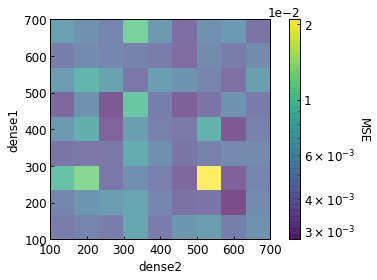

In [ ]:
import matplotlib.colors as colors

cvlog = gridsearch_dir + "/cv-results-0005/cv-results-0005--81-0.003.csv"
cvlog_df = pd.read_csv(cvlog)
dense1, dense2 = [], []

n = cvlog_df['param_layers'].shape[0]
[dense1.append(eval(cvlog_df['param_layers'].iloc[i])['dense1']) for i in range(n)]
[dense2.append(eval(cvlog_df['param_layers'].iloc[i])['dense2']) for i in range(n)]
dense1 = np.array(dense1).reshape(-1,9)
dense2 = np.array(dense2).reshape(-1,9)
metric = (-cvlog_df['mean_test_score'].to_numpy()).reshape(-1,9)
step = (dense2[0,1] - dense2[0,0])/2
extent = (dense2.min()-step, dense2.max()+step, 
          dense1.min()-step, dense1.max()+step)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("dense2")
ax.set_ylabel("dense1")
ax.set_yticks(np.arange(dense1.min(), dense1.max()+100, 100))
ax.set_xticks(np.arange(dense2.min(), dense2.max()+100, 100))
ax.set_yticks(np.arange(dense1.min()-step, dense1.max()+step+100, 100), minor=True)
ax.set_xticks(np.arange(dense2.min()-step, dense2.max()+step+100, 100), minor=True)

im = ax.imshow(metric, extent=extent, origin='lower',
               norm=colors.LogNorm(vmin=metric.min(), vmax=metric.max()), alpha=0.7)
cbar = fig.colorbar(im, ax=ax, format=ticker.ScalarFormatter(), orientation='vertical')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.useOffset=True
cbar.ax.yaxis.set_offset_position('right')
cbar.set_ticks(np.arange(1,7,1)*1e-2)
cbar.set_label('MSE', rotation=270, labelpad=15)
cbar.update_ticks()
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)

plt.tight_layout()
if not os.path.exists(gridsearch_dir + "/cv-results-0005/plots"):
    os.makedirs(gridsearch_dir + "/cv-results-0005/plots")
#plt.savefig(gridsearch_dir + "cv-results-0008/plots/layers_mse.png", dpi=300)
plt.show()

In [ ]:
pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_batch_size,param_dropout,param_init,param_layers,param_learning_rate,param_loss,param_n_in,param_n_out,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
19,7.647874,0.446694,0.128064,0.001722,elu,350,0.02,<tensorflow.python.ops.init_ops_v2.VarianceSca...,"{'dense1': 200, 'dense2': 950}",0.01,mse,3,1,"{'activation': 'elu', 'batch_size': 350, 'drop...",-0.009900,-0.005798,-0.007849,0.002051,1,-0.009690,-0.005778,-0.007734,0.001956
43,8.062202,0.013198,0.128354,0.004108,elu,350,0.02,<tensorflow.python.ops.init_ops_v2.VarianceSca...,"{'dense1': 500, 'dense2': 350}",0.01,mse,3,1,"{'activation': 'elu', 'batch_size': 350, 'drop...",-0.006301,-0.009660,-0.007981,0.001679,2,-0.006133,-0.009716,-0.007924,0.001792
56,8.331532,0.010334,0.132372,0.002134,elu,350,0.02,<tensorflow.python.ops.init_ops_v2.VarianceSca...,"{'dense1': 600, 'dense2': 650}",0.01,mse,3,1,"{'activation': 'elu', 'batch_size': 350, 'drop...",-0.009202,-0.010360,-0.009781,0.000579,3,-0.009140,-0.010551,-0.009845,0.000706
18,7.616110,0.252550,0.128621,0.000367,elu,350,0.02,<tensorflow.python.ops.init_ops_v2.VarianceSca...,"{'dense1': 200, 'dense2': 850}",0.01,mse,3,1,"{'activation': 'elu', 'batch_size': 350, 'drop...",-0.012880,-0.007761,-0.010320,0.002559,4,-0.012919,-0.007619,-0.010269,0.002650
31,7.757794,0.212551,0.130059,0.001233,elu,350,0.02,<tensorflow.python.ops.init_ops_v2.VarianceSca...,"{'dense1': 400, 'dense2': 150}",0.01,mse,3,1,"{'activation': 'elu', 'batch_size': 350, 'drop...",-0.014232,-0.006724,-0.010478,0.003754,5,-0.014200,-0.006673,-0.010437,0.003764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,5.489387,0.205149,0.130755,0.004854,elu,350,0.02,<tensorflow.python.ops.init_ops_v2.VarianceSca...,"{'dense1': 800, 'dense2': 650}",0.01,mse,3,1,"{'activation': 'elu', 'batch_size': 350, 'drop...",-0.055003,-0.023560,-0.039282,0.015721,86,-0.053371,-0.022950,-0.038161,0.015211
2,6.984844,1.475868,0.134458,0.007090,elu,350,0.02,<tensorflow.python.ops.init_ops_v2.VarianceSca...,"{'dense1': 100, 'dense2': 250}",0.01,mse,3,1,"{'activation': 'elu', 'batch_size': 350, 'drop...",-0.068770,-0.013755,-0.041263,0.027507,87,-0.068847,-0.013648,-0.041248,0.027599
50,6.228337,0.764591,0.136899,0.005279,elu,350,0.02,<tensorflow.python.ops.init_ops_v2.VarianceSca...,"{'dense1': 600, 'dense2': 50}",0.01,mse,3,1,"{'activation': 'elu', 'batch_size': 350, 'drop...",-0.051631,-0.037978,-0.044804,0.006827,88,-0.051061,-0.038158,-0.044609,0.006452
88,6.679559,0.890334,0.129483,0.002210,elu,350,0.02,<tensorflow.python.ops.init_ops_v2.VarianceSca...,"{'dense1': 900, 'dense2': 850}",0.01,mse,3,1,"{'activation': 'elu', 'batch_size': 350, 'drop...",-0.063010,-0.036867,-0.049939,0.013072,89,-0.061459,-0.037392,-0.049425,0.012033


# Test training procedures
Can test dataset size or input data transformers 


In [ ]:
from sklearn.model_selection import KFold

# dir to save results
save_dir, test_num = get_modeldir(gridsearch_dir, "procedure-tests", 1)

# hyperparameters
initializer = he_normal()
layers = {'dense1':300, 'dense2':200, 'dense3':100}
best_params = {
    "n_in" : 4,
    "n_out" : 2,
    "layers" : layers,
    "activation" : 'relu',
    "init" : initializer,
    "loss" : 'mse',
    "dropout" : 0.0,
    "learning_rate" : 0.001
}

# loop over the train sizes n_splits times
N_EPOCHS = 200
BATCH_SIZE = 2000
n_splits = 5

# pre-processing input data
trans = 0
ntargets = y_data.shape[2]
mask = radex_mask[:,trans]
X = X_data[~mask]
y = y_data[:,trans][~mask].reshape(-1,ntargets)
x_transformer = MinMaxScaler(feature_range=(-1,1))
y_transformer = StandardScaler()
X_scaled = x_transformer.fit_transform(X)
y_scaled = y_transformer.fit_transform(y)

## temp lines
X_train, X_test, y_train, y_test = fetch_data(X_scaled, y_scaled, 
                                              test_size=0.2, rstate=10)
##
kf = KFold(n_splits=n_splits)
for i, trans in enumerate(transitions[-1:]):
    results = {}
    j = 0
    for train_arg, test_arg in kf.split(X_train, y_train):
        with strategy.scope():
            model=model_fn(**best_params)
            history = model.fit(X_train[train_arg], y_train[train_arg], 
                                epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                                validation_data=(X_train[test_arg], y_train[test_arg]))
            for key, item in history.history.items():
                key = "{}_{}".format(key, j)
                results[key] = item
        j += 1
    # save CV results
    df = pd.DataFrame.from_dict(results)
    df.to_csv(save_dir + "model-%04d.%03d--metrics.csv" % (test_num, i+1),
              header=True, index=False)
    print("\nModel %i/%i done\n" % (i+1, len(transitions)))

Epoch 1/200
102/102 [==============================] - 1s 9ms/step - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.0623 - val_mean_squared_error: 0.0623
Epoch 2/200
102/102 [==============================] - 1s 5ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 3/200
102/102 [==============================] - 1s 5ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0314 - val_mean_squared_error: 0.0314
Epoch 4/200
102/102 [==============================] - 1s 5ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 5/200
102/102 [==============================] - 1s 5ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0397 - val_mean_squared_error: 0.0397
Epoch 6/200
102/102 [==============================] - 1s 5ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 7/200
102/102 [=

# Test input transformers (old_version)

In [ ]:
### load the results of the above test
#results_metrics = pd.read_csv(gridsearch_dir + "data_scaling_test.csv", header=0)

In [ ]:
from matplotlib.pyplot import cm

n = results_metrics.shape[0]; axes = []
ncol = 4
nrow = (n - 1) // ncol + 1 # n // ncol + n % ncol
nsubrow = 2
fig = plt.figure(figsize=(6*ncol,2.5*nsubrow*nrow), dpi=100)
gs_major = fig.add_gridspec(nrow, ncol, hspace=0.5)
xcols = ['c', 'm', 'k']
labels = ['temp', r'$\rm n_{H2}$', 'N(%s)' % molecule]

for row in range(nrow):
    #ncol_cur = n - (nrow - 1) * ncol
    gs_finer = gs_major[row,:].subgridspec(nsubrow, ncol, hspace=0.4, wspace=0.2)
    for col in range(ncol):
        ax1 = fig.add_subplot(gs_finer[0,col])
        ax2 = fig.add_subplot(gs_finer[1,col])
        ax1.set_xlabel("I [K.km/s]")
        ax2.set_xlabel("scaled I")
        [ax.set_yscale('log') for ax in [ax1,ax2]]
        axes.append([ax1, ax2])

        x_transform = results_metrics['x_transform'][row*ncol + col]
        
        ax1.hist(results_metrics['y_data'][row*ncol + col], bins=1000, histtype='step', color='r', label='Radex')
        ax1.hist(results_metrics['preds'][row*ncol + col], bins=1000, histtype='step', color='b', label='DNN')
        [ax2.hist(x_transform.fit_transform(X_data[:,i].reshape(-1,1)), histtype='step', color=xcols[i], label=labels[i]) for i in range(X_data.shape[1])]
        ax2.hist(results_metrics['y_data_scaled'][row*ncol + col], bins=1000, histtype='step', color='r')
        ax2.hist(results_metrics['preds_scaled'][row*ncol + col], bins=1000, histtype='step', color='b')
        
        mse = np.mean((np.array(results_metrics['preds'][row*ncol + col]) - np.array(results_metrics['y_data'][row*ncol + col]))**2)
        title = "MSE=%.2f [K$^2$ km$^2$/s$^2$] \n%s(X), %s(y)" % \
                (mse, results_metrics['x_transform_str'][row*ncol + col], 
                 results_metrics['y_transform_str'][row*ncol + col])
        ax1.set_title(title, fontsize=10)
axes[0][0].legend()
axes[0][1].legend()
#plt.tight_layout()
plt.savefig(gridsearch_dir + "data_scaling_test.png", dpi=200)
plt.show()

# Auxiliary functions

In [11]:
from matplotlib.lines import Line2D

def plot_train_test_metric(history, keys, save_dir=None):
    fig = plt.figure(figsize=(7,3))
    ax = fig.add_subplot(111)
    ax.set_xlabel("N epoch")
    ax.set_ylabel("MSE")
    ax.set_yscale('log')

    xs = np.arange(len(history[keys['val']]))
    minCond = history[keys['val']] == np.min(history[keys['val']])
    minVal = np.array([xs[minCond], np.array(history[keys['val']])[minCond]])

    ax.plot(xs, history[keys['train']], 'r-', marker='.', label='train')
    ax.plot(xs, history[keys['val']], 'b-', marker='.', label='validation')
    ax.scatter(minVal[0], minVal[1], s=60, c='c', zorder=3,  alpha=0.6)
    ax.axvline(minVal[0], color='c', ls=':')
    ax.legend()
    plt.tight_layout()
    if save_dir:
        fname = os.path.join(save_dir, "metric_train_val.pdf")
        plt.savefig(fname, dpi=100)
        plt.close()
    else:
        return fig

def plot_hist_xtransforms(orig, transf, trans, nbins=200, save_dir=None):
    fig = plt.figure(figsize=(7,6))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    fig.subplots_adjust(hspace=0.0)
    ax = fig.add_subplot(111, frameon=False)
    ax.tick_params(axis='both', top=False, right=False, bottom=False, 
                   left=False, labelleft=False, labelbottom=False)
    ax1.tick_params(axis='x', top=True, bottom=False, 
                   left=False, labelbottom=False, labeltop=True)
    ax1.set_xlabel("log$_{10}$ feature range")
    ax1.xaxis.set_label_position('top') 
    ax2.set_xlabel("transformed feature range")
    ax.set_ylabel("Num.", labelpad=30)
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    nfeatures = orig.shape[1]
    colors = ['r','m','b','g']
    labels = ['T', 'nH2', 'dvdr', 'N(%s)' % molecule]
    datasets = [orig, transf]
    axes = [ax1, ax2]
    for ax, data in zip(axes, datasets):
        for i in range(nfeatures):
            ax.hist(data[:,i], bins=nbins, histtype='step', color=colors[i], ls='-')
    legend_lines = [Line2D([0], [0], color=c) for c in colors] # 1 phase
    ax1.legend(legend_lines, labels)
    if save_dir:
        fname = os.path.join(save_dir, "hist_xtransforms.pdf")
        plt.savefig(fname, dpi=100)
        plt.close()
    else:
        return fig

def plot_hist_ytransforms(orig, transf, nbins=200, save_dir=None):
    fig = plt.figure(figsize=(7,6))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    fig.subplots_adjust(hspace=0.0)
    ax = fig.add_subplot(111, frameon=False)
    ax.tick_params(axis='both', top=False, right=False, bottom=False, 
                   left=False, labelleft=False, labelbottom=False)
    ax1.tick_params(axis='x', top=True, bottom=False, 
                   left=False, labelbottom=False, labeltop=True)
    ax1.set_xlabel("target range", labelpad=5)
    ax1.xaxis.set_label_position('top')
    ax2.set_xlabel("transformed target range")
    ax.set_ylabel("Num.", labelpad=30)
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    nfeatures = orig.shape[1]
    labels = ['Flux', 'Tau']
    colors = ['r', 'b']
    datasets = [orig, transf]
    axes = [ax1, ax2]
    for ax, data in zip(axes, datasets):
        for i in range(nfeatures):
            ax.hist(data[:,i], bins=nbins, histtype='step', color=colors[i], 
                    ls='-')
    legend_lines = [Line2D([0], [0], color=c) for c in colors]
    ax1.legend(legend_lines, labels)
    if save_dir:
        fname = os.path.join(save_dir, "hist_ytransforms.pdf")
        plt.savefig(fname, dpi=100)
        plt.close()
    else:
        return fig

def plot_target_pred(pred, target, trans, nbins=200, save_dir=None):
    fig = plt.figure(figsize=(7,6))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    fig.subplots_adjust(hspace=0.0)
    ax = fig.add_subplot(111, frameon=False)
    ax.tick_params(axis='both', top=False, right=False, bottom=False, 
                   left=False, labelleft=False, labelbottom=False)
    ax1.tick_params(axis='x', top=True, bottom=False, 
                   left=False, labelbottom=False, labeltop=True)
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_xlabel(r"$\mathcal{F}$ [K km/s]")
    ax1.xaxis.set_label_position('top')
    ax2.set_xlabel(r"$\tau$")
    ax.set_ylabel("Num.", labelpad=30)
    mse = (np.average(pred - target, axis=0))**2
    ax1.annotate("MSE=%.2f" % (mse[0]),
                 xy=(0,0), xytext=(0.1,0.85), xycoords='axes fraction',
                 fontsize=12)
    ax2.annotate("MSE=%.2f" % (mse[1]),
                 xy=(0,0), xytext=(0.1,0.85), xycoords='axes fraction',
                 fontsize=12)
    colors = ['r','b']
    axes = [ax1, ax2]
    datasets = [target, pred]
    labels = ['prediction', 'target']
    legend_lines = [Line2D([0], [0], color=c) for c in colors]
    ax1.legend(legend_lines, labels)
    for i, ax in enumerate(axes):
        ax.hist(pred[:,i], bins=nbins, histtype='step', color='r')
        ax.hist(target[:,i], bins=nbins, histtype='step', color='b')
    if save_dir:
        fname = os.path.join(save_dir, "hist_target_pred.pdf")
        plt.savefig(fname, dpi=100)
        plt.close()
    else:
        return fig

def plot_model_results(args):
    n, history, keys, x, x_scaled, y, y_scaled, preds, save_dir = args
    plot_train_test_metric(history, keys, save_dir=save_dir)
    #plot_hist_xtransforms(x, x_scaled, n, save_dir=save_dir)
    #plot_hist_ytransforms(y, y_scaled, save_dir=save_dir)
    plot_target_pred(preds, y, n, save_dir=save_dir)

def save_model(save_dir, molecule, trans):
    modeldir = "%s/%s-%04d/" % (save_dir, molecule, trans)
    if not os.path.exists(modeldir):
        os.makedirs(modeldir)
    model.save(modeldir, overwrite=True)
    print("\n Model saved to %s \n" % modeldir)
    return modeldir

def save_transform(transformers, save_dir, trans, ext='.joblib'):
    for key, t in transformers.items():
        joblib.dump(t, save_dir + '%s_transform%s%s%s' % (key, molecule, 
                                                          trans, ext))

# Predictions (best model)

In [12]:
initializer = he_normal()
best_params = {
    "n_in" : 4,
    "n_out" : 2,
    "layers" : {'dense1':300, 'dense2':200, 'dense3':100},
    "activation" : 'relu',
    "init" : initializer,
    "loss" : 'mse',
    "dropout" : 0.1,
    "learning_rate" : 0.001
}

nepochs = 200
batch_size = 2000
patience = 50
x_transformer = MinMaxScaler(feature_range=(-1,1))
y_transformer = QuantileTransformer(n_quantiles=1000, output_distribution='normal')

keys = {"train": "mean_squared_error", "val":"val_mean_squared_error"}
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', 
                                             patience=patience)

nsamples, ntargets = y_data.shape[0], y_data.shape[2]
preds = np.empty_like(y_data)
pred_masked = np.zeros(shape=(nsamples, ntargets))

for i, trans in enumerate(transitions[:6]):
    print("========================")
    print("%s transition %i->%i" % (molecule, trans, trans-1))
    print("========================")
    mask = radex_mask[:,i]
    X_masked = X_data[:][~mask]
    y_masked = y_data[:,i][~mask].reshape(-1,ntargets)
    X_scaled = x_transformer.fit_transform(X_masked)
    y_scaled = y_transformer.fit_transform(y_masked)
    X_train, X_val, y_train, y_val = fetch_data(X_scaled, y_scaled, test_size=0.2)
    
    with strategy.scope():
        model=model_fn(**best_params)
    history = model.fit(X_train, y_train, epochs=nepochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), callbacks=[earlyStop],
                        verbose=0)
    pred = model.predict(X_scaled)
    pred = y_transformer.inverse_transform(pred)
    pred_masked[~mask] = pred
    pred_masked[mask] = np.nan
    pred_masked = np.ma.masked_invalid(pred_masked)
    preds[:,i] = np.copy(pred_masked) # store in general table
    
    # save network and transformers to disk
    mymodel_dir = save_model(new_models_dir, molecule, trans)
    save_transform({'x':x_transformer, 'y':y_transformer}, mymodel_dir, trans)

    args = [i, history.history, keys, X_masked, X_scaled, y_masked, y_scaled, 
            preds[:,i][~mask], mymodel_dir]
    plot_model_results(args)
    print(model.summary(), "\n")

HCN transition 1->0
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./drive/My Drive/colab-notebooks/emuradex/models/HCN/new_models/HCN-0001/assets

 Model saved to ./drive/My Drive/colab-notebooks/emuradex/models/HCN/new_models/HCN-0001/ 

Model: "dnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 300)               1500      
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_______________________________________________________________

# Predistions (best model) TEST

In [ ]:
initializer = tf.keras.initializers.VarianceScaling(scale=1.0, mode='fan_in', 
                                                    distribution="truncated_normal")
best_params = {
    "n_in" : 4,
    "n_out" : 2,
    "layers" : {'dense1':500, 'dense2':350},
    "activation" : 'relu',
    "init" : initializer,
    "loss" : 'mse',
    "dropout" : 0.01,
    "learning_rate" : 0.01
}

nepochs = 100
batch_size = 900
patience = 20
x_transformer = MinMaxScaler(feature_range=(-1,1))
#x_transformer = StandardScaler()
#y_transformer = StandardScaler()
#y_transformer = MinMaxScaler(feature_range=(-1,1))
#y_transformer = PowerTransformer('box-cox')
#y_transformer = QuantileTransformer(n_quantiles=1000, output_distribution='normal', 
#                                    subsample=100000)

#keys = {"train": "output1_mean_squared_error", "val":"val_output1_mean_squared_error"}
#earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_output1_mean_squared_error', 
#                                             patience=patience)
keys = {"train": "mean_squared_error", "val":"val_mean_squared_error"}
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', 
                                             patience=patience)

nsamples, ntargets = y_data.shape[0], y_data.shape[2]
preds = np.empty_like(y_data)
pred_masked = np.zeros(shape=(nsamples, ntargets))

a = [1]
for i, trans in enumerate(a):
    print("========================")
    print("%s transition %i->%i" % (molecule, trans, trans-1))
    print("========================")
    mask = radex_mask[:,i]
    X_masked = X_data[:][~mask]
    y_masked = y_data[:,i][~mask].reshape(-1,ntargets)
    X_scaled = x_transformer.fit_transform(X_masked)
    y_scaled = y_transformer.fit_transform(y_masked)
    X_train, X_val, y_train, y_val = fetch_data(X_scaled, y_scaled, test_size=0.2)
    
    with strategy.scope():
        model=model_fn(**best_params)
    y_train_targets = {'output1':y_train[:,0], 'output2':y_train[:,1]}
    y_val_targets = {'output1':y_val[:,0], 'output2':y_val[:,1]}
    #history = model.fit(X_train, y_train_targets, epochs=nepochs, batch_size=batch_size,
    #                    validation_data=(X_val, y_val_targets), callbacks=[earlyStop])
    history = model.fit(X_train, y_train, epochs=nepochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), callbacks=[earlyStop])
    pred = model.predict(X_scaled)
    #pred = np.concatenate(pred_list, axis=1)
    pred = y_transformer.inverse_transform(pred)
    pred_masked[~mask] = pred
    pred_masked[mask] = np.nan
    pred_masked = np.ma.masked_invalid(pred_masked)
    preds[:,i] = np.copy(pred_masked) # store in general table
    
    # save network and transformers to disk
    mymodel_dir = save_model(new_models_dir, molecule, trans)
    #save_transform({'x':x_transformer, 'y':y_transformer}, mymodel_dir, trans)

    #print("flux", preds[:,0][~mask].min(), preds[:,0][~mask].max(), y_masked.min(), y_masked.max())
    args = [i, history.history, keys, X_masked, X_scaled, y_masked, y_scaled, 
            preds[:,i][~mask], mymodel_dir]
    plot_model_results(args)
    print(model.summary(), "\n")

CS transition 1->0
Epoch 1/100
132/132 [==============================] - 1s 5ms/step - loss: 0.2799 - mean_squared_error: 0.2799 - val_loss: 0.1034 - val_mean_squared_error: 0.1034
Epoch 2/100
132/132 [==============================] - 1s 4ms/step - loss: 0.0762 - mean_squared_error: 0.0762 - val_loss: 0.0798 - val_mean_squared_error: 0.0798
Epoch 3/100
132/132 [==============================] - 1s 4ms/step - loss: 0.0604 - mean_squared_error: 0.0604 - val_loss: 0.0521 - val_mean_squared_error: 0.0521
Epoch 4/100
132/132 [==============================] - 1s 4ms/step - loss: 0.0574 - mean_squared_error: 0.0574 - val_loss: 0.0614 - val_mean_squared_error: 0.0614
Epoch 5/100
132/132 [==============================] - 1s 4ms/step - loss: 0.0510 - mean_squared_error: 0.0510 - val_loss: 0.0502 - val_mean_squared_error: 0.0502
Epoch 6/100
132/132 [==============================] - 1s 4ms/step - loss: 0.0499 - mean_squared_error: 0.0499 - val_loss: 0.0440 - val_mean_squared_error: 0.0440
Epo

In [ ]:
preds[:,0,0][~radex_mask[:,0]].min(), preds[:,0,0][~radex_mask[:,0]].max()

(3.0479998e-17, 99.86649)

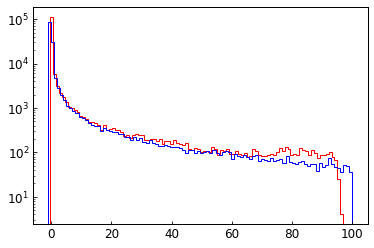

In [ ]:
mask = radex_mask[:,0]
yy_pred = preds[:,0,1][~mask]
plt.hist(yy_pred, histtype='step', color='r', bins=100)
plt.hist(y_data[:,0,1][~mask], histtype='step', color='b', bins=100)
#plt.hist(df_dm19['0'].values[~mask], histtype='step', color='r', bins=100)
plt.yscale('log')

# Load model

In [30]:
my_dir = "./drive/My Drive/colab-notebooks"
# TODO: import emuradex properly
sys.path.insert(1, '{}/{}/'.format(my_dir, "emuradex/"))
import emuradex
import importlib
importlib.reload(emuradex)
#!pip install emulchem
#import emulchem

<module 'emuradex' from './drive/My Drive/colab-notebooks/emuradex/emuradex.py'>

### Timing predictions

In [ ]:
### timing __call__() in loop
def looper_call():
    ys = []
    for i, x in enumerate(X[:1000,:]):
        nfeatures = len(x)
        y = model.call_flux(x.reshape(-1,nfeatures))
        ys.append(y)

t_start = time.time()
looper_call()
t_call = time.time() - t_start
t_call

4.732098817825317

In [ ]:
### timing predict() in loop
def looper():
    ys = []
    for i, x in enumerate(X[:100,:]):
        nfeatures = len(x)
        y = model.predict_flux(x.reshape(-1,nfeatures))
        ys.append(y)

t_start = time.time()
looper()
t_predict = time.time() - t_start
t_predict

4.19287371635437

In [ ]:
### timing predict()
t_start = time.time()
y = model.predict_flux(X)
t_pred = time.time() - t_start
t_pred

0.22665953636169434

In [ ]:
### checking if predict() and __call__() produce the same results
y_call = model.call_flux(X[100].reshape(-1,3))
y_pred = model.predict_flux(X[100].reshape(-1,3))
y_call, y_pred, np.isclose(y_call.item(0), y_pred.item(0))

(array([[0.00044039]]), array([[0.00044039]], dtype=float32), True)

### Radex | Emuradex | Emulchem (2D plots; training data)

In [10]:
def get_bounded_features(X, limits):
    args = np.ones(shape=(X.shape), dtype=bool)
    for key, lims in limits.items():
        args[:,key] = (X[:,key] > lims[0]) & (X[:,key] < lims[1])
    args = np.prod(args, axis=1, dtype=bool)
    return args

n = 0
mask = radex_mask[:,n]
X = 10**X_data[~mask]

# get data compatible with emulchem
#lim_dict = {0:[10, 200], 1:[10**4, 10**6], 2:[-np.inf, np.inf]}
#args_dm19 = get_bounded_features(X, lim_dict)
#print("orig shape", X.shape)
#print("shape for emulchem", X[args_dm19].shape)
#X = X[args_dm19] # for comparison with emulchem

# predict fluxes / taus with these data
specie = emuradex.Radex(molecule, 1)
preds = specie.predict_flux(X, batch_size=2000) # emuradex preds
preds.shape

(158977, 2)

### Make predictions with `Emulchem`

In [ ]:
# make predictions with emulchem

keyword = "-"

if keyword == "gen":
    from tqdm import tqdm
    import emulchem
    ntrans = 1
    fluxes_dm19 = np.zeros((X.shape[0], ntrans), dtype=np.float32)
    for n in np.arange(ntrans):
        specie = emulchem.RadexEmulator(specie=molecule, transition=n)
        i = 0
        for t, nh2, nx in tqdm(zip(X[:,0], X[:,1], X[:,3]), total=X.shape[0]):
            fluxes_dm19[i, n] = specie.get_prediction(t, nh2, nx, 1)
            i += 1
    table = np.hstack((X[:,0,None], X[:,1,None], X[:,3,None]))
    df_dm19 = pd.DataFrame(table)
    cols = [str(i) for i in np.arange(0,ntrans,1)]
    _ = pd.DataFrame(fluxes_dm19, columns=cols)
    df_dm19 = pd.concat([df_dm19, _], axis=1)
    df_dm19.to_csv(radex_data + "/emulator_data/%s-%ik_dm19_emulator.csv" % (molecule, X.shape[0]//1e3), 
                   index=False, header=True)

else:
    dm19_file = glob.glob(radex_data + "/emulator_data/%s*379k_dm19_emulator.csv" % molecule)[0]
    data_dm19 = np.genfromtxt(dm19_file, dtype=np.float64, skip_header=1, delimiter=',')
    fluxes_dm19 = data_dm19[:, 3:]
    
# load the results of the emulator DM20
preds_dm19 = np.array(fluxes_dm19)
dim_dm19 = int(np.round((preds_dm19.shape[0])**(1/3)))
#if dim_dm19 != dim:
#    raise Exception("Dimensions 'dim=%i' and 'dim_dm19=%i' don't agree. Create new DM19 data." % (dim, dim_dm19))

print("DM19 predictions shape = (%i,%i)" % preds_dm19.shape)

DM19 predictions shape = (379771,1)


### Plot LHS samples

In [ ]:
samples_args

array([ 0, 16, 32, 48])

(81, 4)
(81, 4) (81,)
(81, 4) (81,)
(97, 4)
(97, 4) (97,)
(97, 4) (97,)
(76, 4)
(76, 4) (76,)
(76, 4) (76,)
(76, 4)
(76, 4) (76,)
(76, 4) (76,)


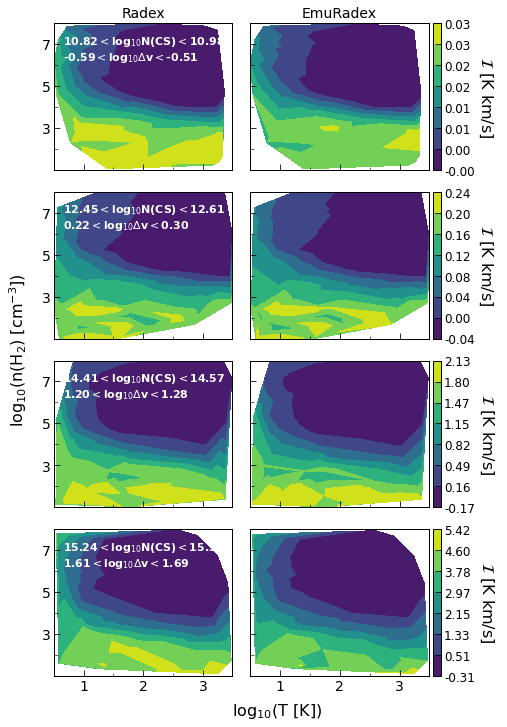

In [16]:
from scipy.ndimage import gaussian_filter
"""
Structure of X_data = [nsamples, nfeatures].
Features: T [K], n(H2) [cm-3], dv/dr [km/s], N(X) [cm-2]
"""

# create a figure
ny, nx = 4, 2
fig, axes = plt.subplots(ny, nx, figsize=(4*nx,3*ny), sharey=True, sharex=True)
#axes = axes.flatten()
fig.subplots_adjust(wspace=0.1, hspace=0.15)
ax = fig.add_subplot(111, frameon=False)
ax.tick_params(axis='both', top=False, right=False, bottom=False, 
               left=False, labelleft=False, labelbottom=False)
ax.set_xlabel("log$_{10}$(T [K])", labelpad=25)
ax.set_ylabel("log$_{10}$(n(H$_2$) [cm$^{-3}$])", labelpad=25)
#for ax0 in axes.flatten():
#    ax0.set_xticks(np.arange(0.0, 4, 1.0), minor=False)
#    ax0.set_xticks(np.arange(0.5, 3.5, 0.5), minor=True)
#    ax0.set_yticks(np.arange(2, 9, 2), minor=False)
#    ax0.set_yticks(np.arange(2, 9, 1), minor=True)

nbins = 50
#samples_args = [1, 10, 20, 30, 39]
samples_args = [5, 15, 27, 32]
#samples_args = np.linspace(0, nbins-2, ny, dtype=int)
for i, ax_row in enumerate(axes):
    # get masked data
    ntrans = 0
    mask = radex_mask[:,ntrans]
    #X, y = np.log10(X_data[~mask][args_dm19]), y_data[~mask][args_dm19]
    X, y = X_data[~mask], y_data[:,0][~mask]

    # dvdr and N(X) columns
    axis2 = [X[:,2].min(), X[:,2].max()]
    axis3 = [X[:,3].min(), X[:,3].max()]

    # bin the dvdr and N(X) columns
    bins2 = np.linspace(axis2[0], axis2[1], nbins)
    bins3 = np.linspace(axis3[0], axis3[1], nbins)
    lb2, ub2 = bins2[:-1], bins2[1:] # bins edges
    lb3, ub3 = bins3[:-1], bins3[1:]

    # arguments of the data within a given N(X) bin
    j = samples_args[i]
    args = (X[:,3] >= lb3[j]) & (X[:,3] <= ub3[j])
    args2 = (X[:,2] >= lb2[j]) & (X[:,2] <= ub2[j])
    args = args * args2
    Nx_min, Nx_max = X[args][:,3].min(), X[args][:,3].max()
    dvdr_min, dvdr_max = X[args][:,2].min(), X[args][:,2].max()
    print(X[args].shape)
    
    # plot the selected data
    flux_data = [y[args,1], preds[args,1]]#, preds_dm19[args,0]] # radex, emuradex, emulchem
    flux_min = np.min([flux_data[i].min() for i in range(len(flux_data))])
    flux_max = np.max([flux_data[i].max() for i in range(len(flux_data))])
    levels = np.linspace(flux_min, flux_max, 8) # contour levels
    for ax, yy in zip(ax_row, flux_data):
        xx = X[args]
        print(xx.shape, yy.shape)
        #im = ax.scatter(xx[:,0], xx[:,1], c=yy, s=0.5)
        if i == 0:
            im = ax.tricontourf(xx[:,0], xx[:,1], yy, levels=levels)
        else:
            im = ax.tricontourf(xx[:,0], xx[:,1], yy, levels=levels)
        #ax.set_xticks(np.arange(1.5, 2.5, 0.5), minor=False)
        #ax.set_xticks(np.arange(1.1, 2.4, 0.1), minor=True)
        #ax.set_yticks(np.arange(4.5, 6, 0.5), minor=False)
        #ax.set_yticks(np.arange(4.1, 6, 0.1), minor=True)
        ax.set_xticks(np.arange(1, 4, 1), minor=False)
        ax.set_xticks(np.arange(1, 3.5, 0.5), minor=True)
        ax.set_yticks(np.arange(1, 9, 2), minor=False)
        ax.set_yticks(np.arange(1, 9, 1), minor=True)

    cbar = fig.colorbar(im, ax=list(ax_row), pad=0.01)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.formatter.useOffset=True
    cbar.ax.yaxis.set_offset_position('right')
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.yaxis.offsetText.set(size=12)
    cbar.ax.set_yticklabels(["%.2f" % x for x in levels])
    cbar.set_label("$\mathcal{I}$ [K km/s]", rotation=270, labelpad=20)
    text = "%.2f$<$log$_{10}$N(%s)$<$%.2f\n%.2f$<$log$_{10}\Delta$v$<$%.2f" % (Nx_min, molecule, 
                                                               Nx_max, 
                                                               dvdr_min, dvdr_max)
    ax_row[0].text(0.05, 0.75, text, transform=ax_row[0].transAxes, 
                    size=11, color='w', weight='bold')
titles = ['Radex', 'EmuRadex']#, 'Emulchem']
for ax, title in zip(axes[0], titles):
    ax.set_title(title)
#plt.tight_layout()
#plt.savefig(specie.emul_path + "/radex_emuradex_taus.pdf")
plt.show()

### Error plots (Radex vs EmuRadex)

In [31]:
def get_cfs(counts, cfs=None):
    
    '''
    Find the counts that correspond to the confidence intervals provided.
    
    Args:
        counts: the counts returned from a pyplot.hist2d function or np.histogram2d.
        cfs (list): the confidence intervals requested -  e.g., [0.68,0.95,0.99]
        
    Returns:
        levels (list): the count values corresponding to the requested confidence
        regions, for plotting contours.
    '''
    if cfs == None:
        cfs = [0.687, 0.95, 0.99]
    
    points = np.copy(np.sort(counts,axis=None))[::-1]
    total = points.sum()
    
    cum = 0.0
    levels=[]
    cfs = np.sort(cfs)
    for cf in cfs:
        cumsum = np.cumsum(points)
        point = points[cumsum>=cf*total]
        if len(point) > 1:
            point = points[cumsum>=cf*total][0]
        levels.append(point)
    return np.array(levels[::-1])

In [32]:
n = 0
preds = np.zeros_like(y_data)
pred_masked = np.zeros(shape=(y_data.shape[0], y_data.shape[-1]))
for i, n in enumerate(transitions):
    mask = radex_mask[:,i]
    X = 10**X_data[~mask]
    specie = emuradex.Radex(molecule, n)
    pred_masked[~mask] = specie.predict_flux(X, batch_size=2000) # emuradex preds
    pred_masked[mask] = np.nan
    pred_masked = np.ma.masked_invalid(pred_masked)
    preds[:,i] = np.copy(pred_masked) # store in general table
    print("J=%i-%i done" % (i+1, i))
preds.shape

J=1-0 done
J=2-1 done
J=3-2 done
J=4-3 done
J=5-4 done
J=6-5 done
J=7-6 done
J=8-7 done
J=9-8 done
J=10-9 done
J=11-10 done
J=12-11 done
J=13-12 done
J=14-13 done
J=15-14 done
J=16-15 done
J=17-16 done
J=18-17 done
J=19-18 done
J=20-19 done


(200000, 20, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


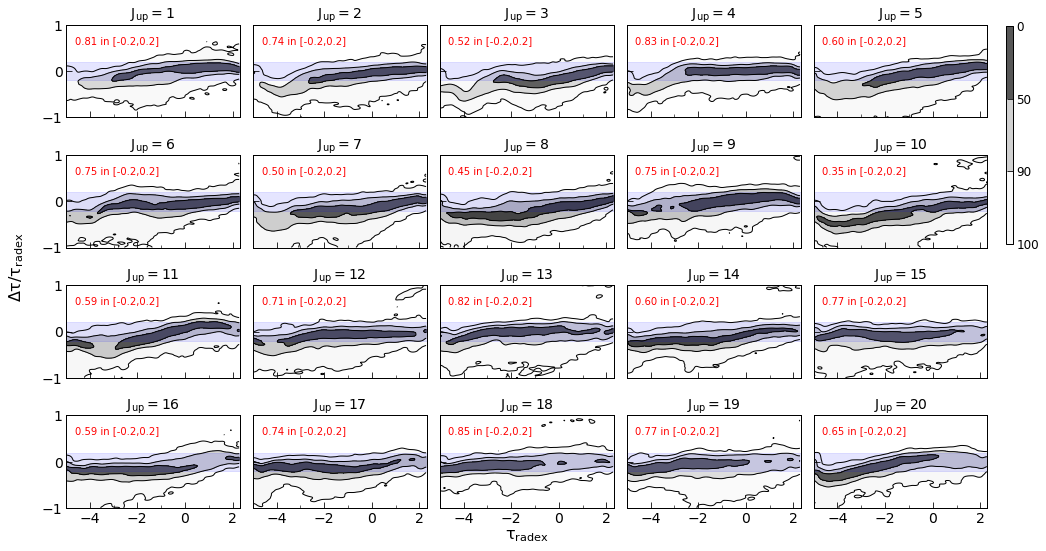

In [ ]:
from scipy.interpolate import interp2d, bisplev
from scipy.ndimage import gaussian_filter
from matplotlib import ticker

# Radex - EmuRadex
del_flux = (y_data - preds) / y_data
del_flux = np.ma.masked_invalid(del_flux)

# make plot
ny, nx = 4, 5
fig, axes = plt.subplots(ny, nx, figsize=(3*nx,2*ny), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.15, right=0.86)
ax = fig.add_subplot(111, frameon=False)
ax.tick_params(axis='both', top=False, right=False, bottom=False, 
               left=False, labelleft=False, labelbottom=False)
#ax.set_xlabel(r"$\rm \mathcal{I}_{radex}$", labelpad=20)
#ax.set_ylabel(r"$\rm \Delta \mathcal{I}/\mathcal{I}_{radex}$", labelpad=40)
ax.set_xlabel(r"$\rm \tau_{radex}$", labelpad=20)
ax.set_ylabel(r"$\rm \Delta \tau/\tau_{radex}$", labelpad=40)
ax.tick_params(axis='both', labelbottom=False, labelleft=False)
xmin, xmax = np.log10(1e-5), np.log10(200)
ymin, ymax = -1, 1
bins = np.array([[xmin, xmax],[ymin, ymax]])
axes[0][0].set_ylim(ymin, ymax)
axes[0][0].set_xlim(xmin, xmax)
for ax in axes.flatten():
    ax.set_xticks(np.arange(-4,4,2), minor=False)
    ax.set_xticks(np.arange(-5,2.5,1), minor=True)
crs_fmt = ticker.FuncFormatter(lambda x, pos: "%i" % int(x) )

# loop over transitions
t = 0 # target vector
for i, ax in enumerate(axes.flatten()):
    # iteration data
    xx = y_data[:,i,t][~radex_mask[:,i]]# + 0.01 # offset for taus
    yy = del_flux[:,i,t][~radex_mask[:,i]]

    ax.set_title(r"$\rm J_{up} = %i$" % (i + 1))
    bound = 0.2
    cond = np.abs(yy) < bound
    ax.text(0.05, 0.8, "%.2f in [-%.1f,%.1f]" % 
            (len(yy[cond]) / len(yy), bound, bound),
            transform=ax.transAxes, color='r')
    
    # bins for intepolation
    bins1, xedges1, yedges1 = np.histogram2d(np.log10(xx), yy, normed=False, 
                                             bins=[70,60], range=bins)
    xmids1 = (xedges1[1:] + xedges1[:-1]) / 2.0
    ymids1 = (yedges1[1:] + yedges1[:-1]) / 2.0
    interp1 = interp2d(ymids1, xmids1, bins1, kind='linear')
    
    # bins for plotting
    bins1, xedges1, yedges1 = np.histogram2d(np.log10(xx), yy, normed=False, 
                                             bins=[150,200], range=bins)
    xmids1 = (xedges1[1:] + xedges1[:-1]) / 2.0
    ymids1 = (yedges1[1:] + yedges1[:-1]) / 2.0
    
    yy1, xx1 = np.meshgrid(ymids1, xmids1)
    interpMin1, interpMax1 = interp1(ymids1, xmids1).min(), interp1(ymids1, xmids1).max()
    #if i % 5 == 0:
    levels1 = get_cfs(interp1(ymids1, xmids1), cfs=[0, 0.5, 0.9])
    levels1 = np.insert(levels1, 0, interpMin1+1)
    H = gaussian_filter(interp1(ymids1, xmids1), sigma=2.0) # smoothed contours
    im = ax.contourf(xx1, yy1, H, levels=levels1, cmap='Greys')
    cr_ax = ax.contour(xx1, yy1, H, levels=levels1, colors='k', linewidths=1.0)
    ax.fill_between(np.arange(-5, 4, 1), -0.2, 0.2, color='b', alpha=0.1)

cbar = fig.colorbar(im, ax=axes, pad=0.01, aspect=30, shrink=0.5, anchor=(2,1.18))
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.useOffset=True
cbar.ax.yaxis.set_offset_position('right')
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.offsetText.set(size=12)
cbar.ax.set_yticklabels(["%i" % (x) for x in [100, 90, 50, 0]])

plt.tight_layout(rect=(0,0,0.95,1))
#plt.savefig(specie.emul_path + "/radex_emuradex_del_tau.pdf")
plt.show()

In [ ]:
for i, _ in enumerate(transitions):
    yy = y_data[:,i,t][~radex_mask[:,i]]
    print("%.2f, %.2f" % (len(yy[(yy>-0.01) & (yy<0)]) / len(yy), len(yy[yy<-0.01]) / len(yy)))

0.16, 0.05
0.11, 0.03
0.08, 0.01
0.06, 0.01
0.04, 0.01
0.03, 0.00
0.02, 0.00
0.02, 0.00
0.01, 0.00
0.00, 0.00
0.00, 0.00
0.00, 0.00
0.00, 0.00
0.00, 0.00
0.00, 0.00
0.00, 0.00
0.00, 0.00
0.00, 0.00
0.00, 0.00
0.00, 0.00


### Emuradex vs Emulchem (2D plots; unseen data)

In [ ]:
#from pyDOE import lhs
samples = np.random.rand(400000, 4)
X_new_data = np.zeros_like(X_data)
X_new_data[:,0] = np.power(10,(3.5 - 0.5) * samples[:,0] + 0.5)
X_new_data[:,1] = np.power(10,(8 - 1) * samples[:,1] + 1)
X_new_data[:,2] = np.power(10,(3 - (-1)) * samples[:,2] + (-1))
X_new_data[:,3] = np.power(10,(18-10)*samples[:,3]+10)

# predict

radex_mask_preds = get_radex_mask(preds, cuts)

# Radex Output


### DM19 emulator

In [ ]:
!pip install emulchem

     |████████████████████████████████| 53.4MB 64kB/s 


In [ ]:
keyword = "gen"

if keyword == "gen":
    from tqdm import tqdm
    import emulchem
    ntrans = 1
    nn = 20000
    fluxes_dm19 = np.zeros((X_data[:nn].shape[0], ntrans), dtype=np.float32)
    print(fluxes_dm19.shape)
    for n in tqdm(np.arange(ntrans)):
        specie = emulchem.RadexEmulator(specie=molecule, transition=n)
        i = 0
        for t, nh2, nx in zip(X_data[:nn,0], X_data[:nn,1], X_data[:nn,2]):
            fluxes_dm19[i, n] = specie.get_prediction(t, 10**nh2, 10.0**nx, 1)
            i += 1
    df_dm19 = pd.DataFrame(data_df.iloc[:nn,:3])
    cols = [str(i) for i in np.arange(0,ntrans,1)]
    _ = pd.DataFrame(fluxes_dm19, columns=cols)
    df_dm19 = pd.concat([df_dm19, _], axis=1)
    df_dm19.to_csv(radex_data + "/emulator_data/%s-%ik_dm19_emulator.csv" % (molecule, X_data.shape[0]//1e3), 
                   index=False, header=True)

else:
    dm19_file = glob.glob(radex_data + "/emulator_data/%s*_dm19_emulator.csv" % molecule)[0]
    data_dm19 = np.genfromtxt(dm19_file, dtype=np.float64, skip_header=1, delimiter=',')
    fluxes_dm19 = data_dm19[:, 3:]
    
# load the results of the emulator DM20
out_dm19 = np.array(fluxes_dm19)
dim_dm19 = int(np.round((out_dm19.shape[0])**(1/3)))
#if dim_dm19 != dim:
#    raise Exception("Dimensions 'dim=%i' and 'dim_dm19=%i' don't agree. Create new DM19 data." % (dim, dim_dm19))

print("DM19 predictions shape = (%i,%i)" % out_dm19.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

(20000, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
100%|██████████| 1/1 [00:11<00:00, 11.85s/it]

DM19 predictions shape = (20000,1)


(array([14096.,  1401.,  1447.,  1135.,   682.,   365.,   321.,   263.,
          184.,   106.]),
 array([-0.24702732,  8.190531  , 16.62809   , 25.065647  , 33.503204  ,
        41.940765  , 50.378323  , 58.81588   , 67.25344   , 75.690994  ,
        84.128555  ], dtype=float32),
 <a list of 10 Patch objects>)

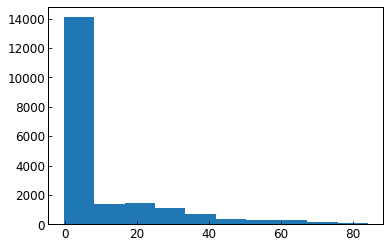

In [ ]:
plt.hist(df_dm19['0'].values)


### Comparison (Radex - current emu - DM19)

Sort data arrays by density


In [ ]:
a, b, c, d_data, d_net, d_dm19 = [], [], [], [], [], []
y_data_masked = y_data.copy()
y_data_masked[~radex_nomask] = np.nan
y_data_masked = np.ma.masked_invalid(y_data_masked)
preds_masked = np.zeros(shape=y_data.shape)
preds_masked[radex_nomask] = preds
preds_masked[~radex_nomask] = np.nan
preds_masked = mp.ma.masked_invalid(preds_masked)

#tran = 0
dim3 = dim**2
n_range = range(dim)
for i in n_range:
    a.append(X_table[i::dim,0])
    b.append(X_table[i::dim,1])
    c.append(X_table[i,2])
    d_radex.append(y_table[i::dim,:])
    d_net.append(pred_table_phys[i::dim,:])
    d_dm19.append(out_dm19[i::dim,:])
c, a, b, d_radex, d_net, d_dm19 = [np.array(t) for t in zip(*sorted(zip(c, a, b, d_radex, d_net, d_dm19)))]
d_radex = d_radex.reshape(-1, dim3, 10)
d_net = d_net.reshape(-1, dim3, 10)
d_dm19 = d_dm19.reshape(-1, dim3, 10)

In [ ]:
trans = 0
ims, axs = [], []
for i in range(dim):
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    fig.subplots_adjust(wspace=0.3)
    ax1.set_title(r"$\rm Radex $")
    ax2.set_title(r"$\rm test \; Network $")
    ax3.set_title(r"$\rm DM19 $")
    ax0 = fig.add_subplot(111, frameon=False)
    ax0.set_xlabel(r"$\rm T (K) $", labelpad=5)
    ax0.set_ylabel(r"$\rm n_{H2} (cm^{-3}) $", labelpad=10)
    ax0.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    fig.text(0.06, 0.93, "N(%s)=%3.1e cm$^{-2}$" % (molecule, 10**c[i]), fontsize=12)
    
    im1 = ax1.tricontourf(a[i], b[i], d_radex[i,:,trans], levels=np.linspace(d_radex[i,:,trans].min(), d_radex[i,:,trans].max(), 15))
    im2 = ax2.tricontourf(a[i], b[i], d_net[i,:,trans], levels=np.linspace(d_net[i,:,trans].min(), d_net[i,:,trans].max(), 15))
    im3 = ax3.tricontourf(a[i], b[i], d_dm19[i,:,trans], levels=np.linspace(d_dm19[i,:,trans].min(), d_dm19[i,:,trans].max(), 15))
    ax1.scatter(a[i][d_radex[i,:,trans] > 200], b[i][d_radex[i,:,trans] > 200], s=10, c='r', marker='.')
    ax1.scatter(a[i][d_radex[i,:,trans] < 0], b[i][d_radex[i,:,trans] < 0], s=10, c='b', marker='.')
    ax2.scatter(a[i][d_net[i,:,trans] > 200], b[i][d_net[i,:,trans] > 200], s=10, c='r', marker='.')
    ax2.scatter(a[i][d_net[i,:,trans] < 0], b[i][d_net[i,:,trans] < 0], s=10, c='b', marker='.')
    ax3.scatter(a[i][d_dm19[i,:,trans] > 200], b[i][d_dm19[i,:,trans] > 200], s=10, c='r', marker='.')
    ax3.scatter(a[i][d_dm19[i,:,trans] < 0], b[i][d_dm19[i,:,trans] < 0], s=10, c='b', marker='.')
    ims.extend([im1, im2, im3]); axs.extend([ax1, ax2, ax3])

    for im, ax in zip(ims, axs):
        ax.set_xticks([10, 50, 100, 150, 200])
        ax.set_yticks(np.array([0.1, 2, 4, 6, 8, 10])*1e5)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True)
        cbar = fig.colorbar(im, ax=ax, format=ticker.ScalarFormatter())
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.useOffset=True
        cbar.ax.yaxis.set_offset_position('right')
        cbar.ax.tick_params(labelsize=12)
        cbar.ax.yaxis.offsetText.set(size=12)
        cbar.update_ticks()
    cbar.set_label("flux [K.km/s]", rotation=270, labelpad=15)
    
    plt.tight_layout(rect=(0,-0.1,1.0,0.95))
    #plt.savefig(models_dir + "model-0001/plots/flux_plots/radex_emu_dm19_%s%i.png" % (molecule, i), dpi=300)
    plt.savefig(drive_dir + "plots/HCO+/fluxes/radex_emu_dm19_%s%i.png" % (molecule, i), dpi=300)
    plt.show()
    plt.close(fig)

Output hidden; open in https://colab.research.google.com to view.

### Radex - EmuRadex intensity errors

## SLED plots (Radex vs EmuRadex)

In [ ]:
samples_args

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  8,  9, 10, 11, 12],
       [13, 14, 16, 17, 18, 19],
       [20, 21, 22, 24, 25, 26],
       [27, 28, 29, 30, 32, 33],
       [34, 35, 36, 37, 38, 40]])

j= 0
j= 1
j= 2
j= 3
j= 4


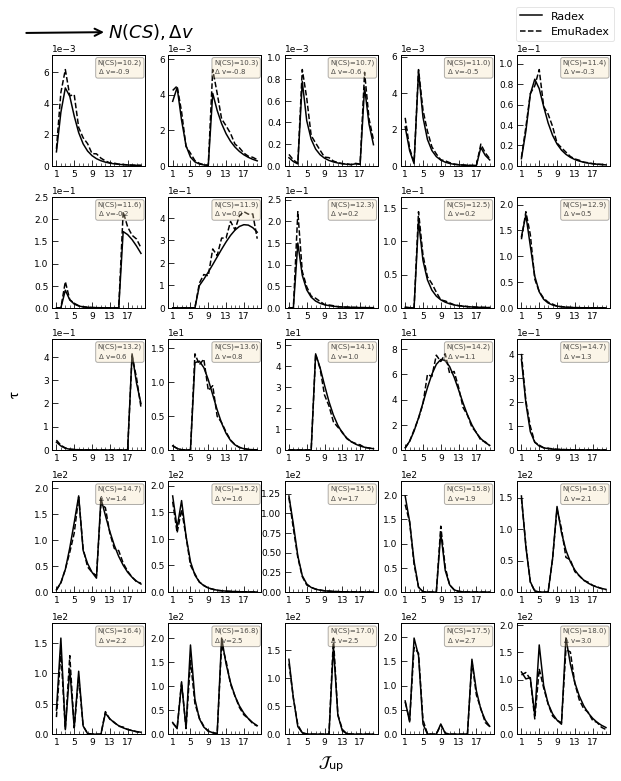

In [33]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

nsub = 5
#n = dim // nsub
fig, axs = plt.subplots(nsub,nsub, figsize=(2*nsub, 2.5*nsub), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =.28, wspace=.25)
axs = axs.ravel()
ax = fig.add_subplot(111, frameon=False)
ax.tick_params(axis='both', top=False, right=False, bottom=False, 
               left=False, labelleft=False, labelbottom=False)
ax.set_xlabel(r"$\rm \mathcal{J}_{up}$", labelpad=20)
#ax.set_ylabel(r"$\rm \mathcal{I} \; [K.km/s]$", labelpad=30.0)
ax.set_ylabel(r"$\rm \mathcal{\tau}$", labelpad=30.0)
ax.annotate(r'$N(%s), \Delta v$' % molecule, xy=(-0.05, 1.032), xycoords='axes fraction', xytext=(0.1, 1.025), 
            arrowprops=dict(arrowstyle="<-", lw=2.0, color='k'), fontsize=18)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)

nbins = 40
t = 0
samples_args = np.linspace(0, nbins-2, nsub**2, dtype=int).reshape(nsub,nsub)
for j in range(nsub): # loop over dim
    for i in range(nsub): # loop over column densities
        sled_radex, sled_emu = [], []
        ax = axs[i + j*nsub]
        for n, _ in enumerate(transitions):
            # get masked data
            mask = radex_mask[:,n]
            X, y, ypred = X_data[~mask], y_data[~mask], preds[~mask]
            # dvdr and N(X) columns
            axis0 = [X[:,0].min(), X[:,0].max()]
            axis2 = [X[:,2].min(), X[:,2].max()]
            axis3 = [X[:,3].min(), X[:,3].max()]
            # bin the dvdr and N(X) columns
            bins0 = np.linspace(axis0[0], axis0[1], nbins)
            bins2 = np.linspace(axis2[0], axis2[1], nbins)
            bins3 = np.linspace(axis3[0], axis3[1], nbins)
            lb0, ub0 = bins0[:-1], bins0[1:] # bins edges
            lb2, ub2 = bins2[:-1], bins2[1:] # bins edges
            lb3, ub3 = bins3[:-1], bins3[1:]
            # arguments of the data within a given N(X) bin
            k = samples_args[j,i]
            args = (X[:,3] >= lb3[k]) & (X[:,3] <= ub3[k])
            args2 = (X[:,2] >= lb2[k]) & (X[:,2] <= ub2[k])
            if (i==0) & (n==0):
                print("j=", j)
            #    args0 = (X_data[:,0] >= lb0[k]) & (X_data[:,0] <= ub0[k])
            #    args2 = (X_data[:,2] >= lb2[k]) & (X_data[:,2] <= ub2[k])
            args = args *  args2
            # plot the selected data
            flux = [y[args,n,t], ypred[args,n,t]]
            sled_radex.append(flux[0][0]) # take one flus from a batch
            sled_emu.append(flux[1][0])
            
        ax.plot(transitions, sled_radex, 'k-', label='Radex')
        ax.plot(transitions, sled_emu, 'k--', label='EmuRadex')

        #text1 = r"$\rm T=%4.1f$" % (X[args,0][0])
        text2 = "N(%s)=%.1f)" % (molecule, X[args,3][0])
        text3 = "$\Delta$ v=%.1f" % (X[args,2][0])
        text = "{}\n{}".format(text2, text3)
        ax.set_xticks(transitions[0::4], minor=False)
        ax.set_xticks(transitions, minor=True)
        ax.tick_params(axis='both', labelsize=9)
        offset_text = ax.yaxis.get_offset_text()
        offset_text.set_size(9)
        ylims = ax.get_ylim()
        ax.set_ylim(0, 1.1*ylims[1])
        ax.text(0.49, 0.96, text, verticalalignment='top', 
                             bbox=props, fontsize=7, alpha=0.7,
                             transform=ax.transAxes)
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True)
axs[nsub-1].legend(bbox_to_anchor=(1.1, 1.48))
#ax.arrow(x=-0.1, y=1.1, dx=0.0, dy=-6.0, fc="k", ec="k", 
#         head_width=1.5, head_length=1, transform=ax.transAxes)
#ax.annotate('T', xy=(-0.053, 1.0), xycoords='axes fraction', xytext=(-0.06, 0.85), 
#            arrowprops=dict(arrowstyle="<-", lw=2.0, color='k'), fontsize=18)

#plt.tight_layout()
#plt.savefig(specie.emul_path + "/radex_emuradex_sled_fluxes.pdf")
plt.show()

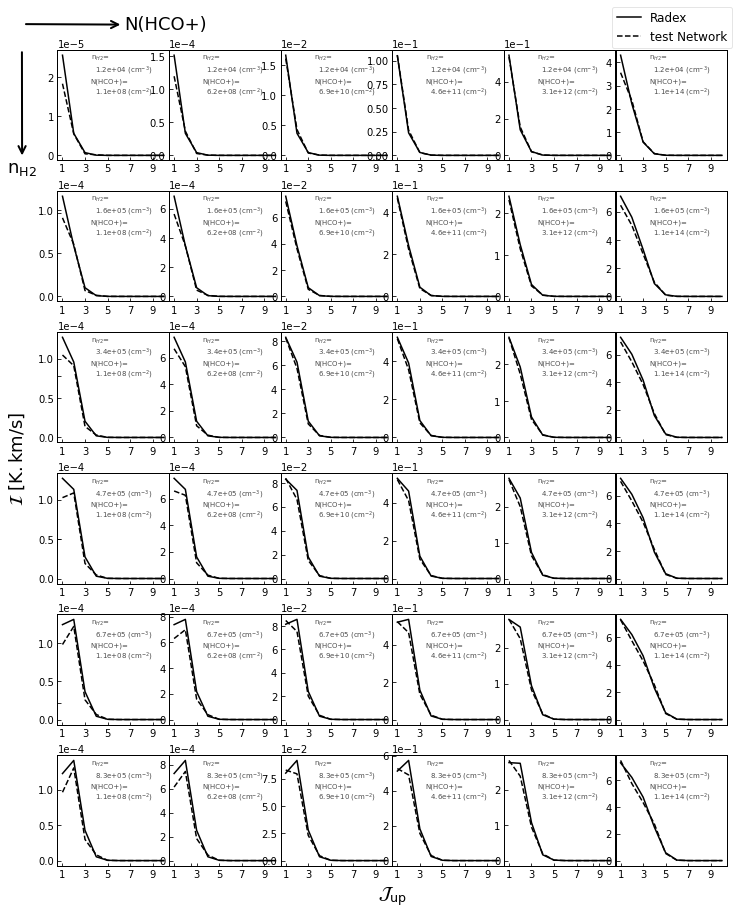

In [ ]:
nsub = 6
n = dim // nsub

fig, axs = plt.subplots(nsub,nsub, figsize=(2*nsub, 2.5*nsub), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =.28, wspace=.001)
axs = axs.ravel()

for j in range(nsub): # loop over dim
    for i in range(nsub): # loop over column densities
        b_sorted, d_radex_sorted, d_net_sorted = [np.array(t) for t in zip(*sorted(zip(b[0,::dim], d_radex[n*i, ::dim], d_net[n*i, ::dim])))]

        axs[i + j*nsub].plot(np.arange(1,11), d_radex_sorted[:, :10][n*j], 'k-', label='Radex')
        axs[i + j*nsub].plot(np.arange(1,11), d_net_sorted[:, :10][n*j], 'k--', label='test Network')

        text = "n$_{H2}$=\n  %.1e (cm$^{-3}$)\n" % (b_sorted[n*j]) + "N(%s)=\n  %.1e (cm$^{-2}$)" % (molecule, 10**c[n*i])
        axs[i + j*nsub].xaxis.set_ticks(np.arange(1, 11, 2))
        axs[i + j*nsub].text(0.3, 0.6, text, transform=axs[i + j*nsub].transAxes, fontsize=7, alpha=0.7)
        axs[i + j*nsub].yaxis.set_major_formatter(ticker.ScalarFormatter())
        axs[i + j*nsub].ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True)
axs[nsub-1].legend(bbox_to_anchor=(1.1, 1.45))
#[axs[nsub * i].set_ylabel(r"$\rm \mathcal{I} \; [K.km/s]$", fontsize=14) for i in range(nsub)]
ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r"$\rm \mathcal{J}_{up}$", labelpad=20, fontsize=18)
ax.set_ylabel(r"$\rm \mathcal{I} \; [K.km/s]$", labelpad=30.0, fontsize=18)
ax.tick_params(axis='both', labelbottom=False, labelleft=False)

#ax.arrow(x=-0.1, y=1.1, dx=0.0, dy=-6.0, fc="k", ec="k", 
#         head_width=1.5, head_length=1, transform=ax.transAxes)
ax.annotate(r'$\rm n_{H2}$', xy=(-0.053, 1.0), xycoords='axes fraction', xytext=(-0.075, 0.85), 
            arrowprops=dict(arrowstyle="<-", lw=2.0, color='k'), fontsize=18)
ax.annotate('N(%s)' % molecule, xy=(-0.05, 1.032), xycoords='axes fraction', xytext=(0.1, 1.025), 
            arrowprops=dict(arrowstyle="<-", lw=2.0, color='k'), fontsize=18)
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

#plt.tight_layout()
#plt.savefig(drive_dir + "plots/HCO+/sled2-%s.png" % molecule, dpi=300)
plt.show()

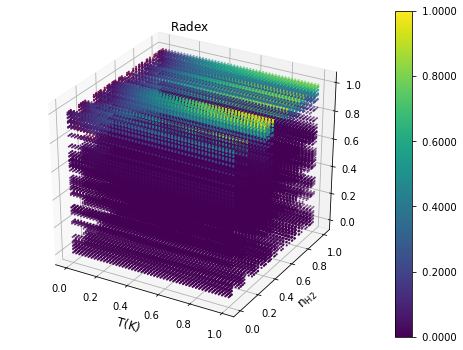

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

a, b, c, d_data, d_net = [], [], [], [], []
dim = 30
n_range = range(1,30)

a = X_data[:, 0]
b = X_data[:, 1]
c = X_data[:, 2]
d_data = y_data.flatten()

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121, projection="3d")
ax1.set_title(r"$\rm Radex $")
ax1.set_ylabel(r"$\rm n_{H2} $")
ax1.set_xlabel(r"$\rm T (K) $")
labelticks = ticker.FuncFormatter(lambda x, pos: "%7.4f" % x)
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter())


cond = (d_data > 0.05) & (d_data < 0.09)
im1 = ax1.scatter(a, b, c, c=d_data, s=1.0);
im1 = ax1.scatter(a[cond], b[cond], c[cond], c='r', s=1.0);
cbar1 = fig.colorbar(im1, ax=ax1, format=labelticks)

In [ ]:
d_data.shape, d_data[(d_data > 0.2) & (d_data < 0.3)].shape

((125000,), (4475,))

# Load a model

In [ ]:
"""with tf.Session() as sess:
    saver.restore(sess, "tf_logs/run-20200413200844/my_model_final.ckpt")
    #X_new_scaled = X_test[:20]
    y_pred = output.eval(feed_dict={X: X_test[:20]})
y_pred"""